In [2]:
import pandas as pd
import numpy as np
import os
import pickle
import json
import torch
from torch import nn
from torch.nn import functional as F
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import glob
import significantdigits as sig
import matplotlib.image as mpimg
import glob
from IPython.display import display
from IPython.display import Image as Im
from PIL import Image
from matplotlib.colors import LogNorm, Normalize
from matplotlib.ticker import MaxNLocator
from matplotlib.colors import TwoSlopeNorm
import random
import nibabel as nib
from nilearn import plotting
from matplotlib.colors import LinearSegmentedColormap
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from scipy.stats import ttest_rel
from typing import Tuple
import matplotlib
import re
from concurrent.futures import ThreadPoolExecutor
import threading
from scipy import stats
from nilearn import masking, image
import scipy.ndimage as ndimage
from nan_ops import NaNPool2d, NaNConv2d



## Embeddings

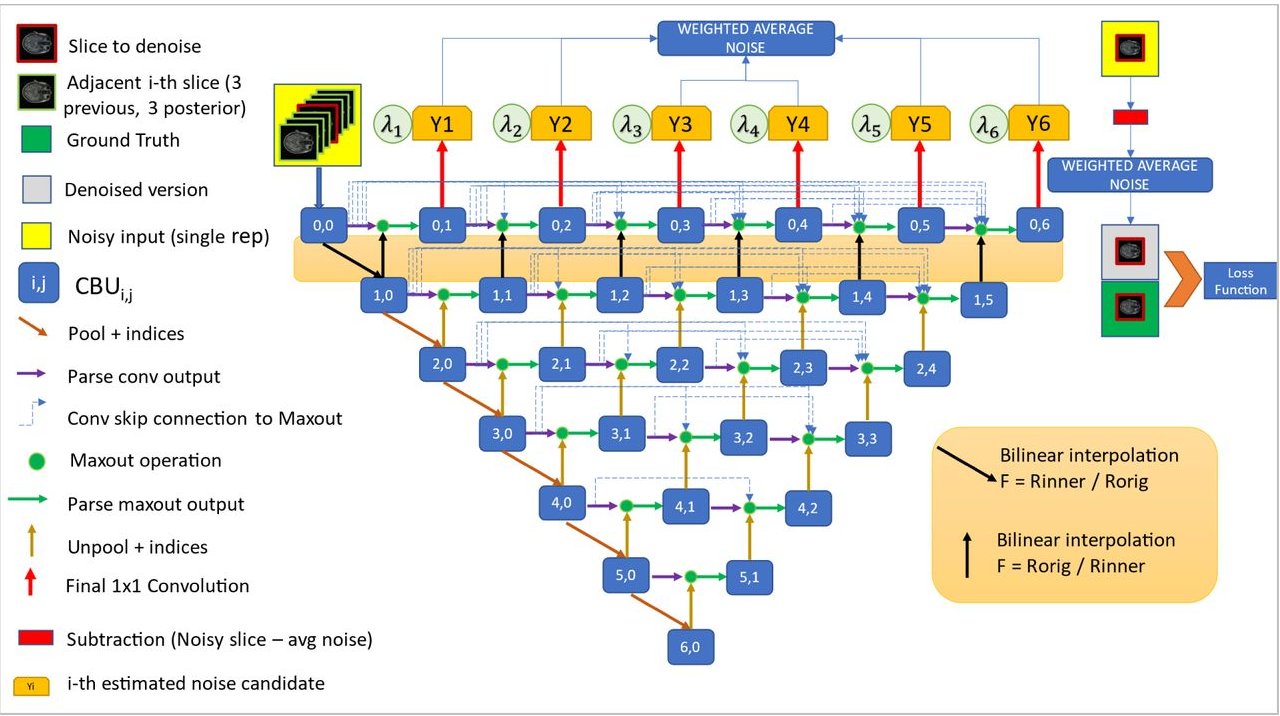

### Visualize Embeddings Across Thresholds

In [19]:
def graph_arch(name, cmap, nan_root, plane, cut, min = None, max = None):
    num_rows = 8
    padding = 0.02

    # Create a figure
    fig = plt.figure(figsize=(30, 25))

    num_cols = 6
    total_width = num_cols / num_rows
    total_width_with_padding = total_width + (num_cols - 1) * padding
    left_start = (1 - total_width_with_padding) / 2
    for col in range(6):
        # Calculate the subplot position with padding
        left = left_start + col * (1 / num_rows + padding)
        bottom = (num_rows  - 1) / num_rows  # Reverse the row position
        width = 1 / num_rows - padding
        height = 1 / num_rows - padding
        
        # Add subplot with the calculated position
        ax = fig.add_axes([left, bottom, width, height])
        ax.set_visible(True)

    # Plot heatmaps in a reverse pyramid shape with padding
    for row in range(num_rows):
        if row != 0:
            num_cols = num_rows - row
            total_width = num_cols / num_rows
            total_width_with_padding = total_width + (num_cols - 1) * padding
            left_start = (1 - total_width_with_padding) / 2
            
            for col in range(num_cols):
                # Calculate the subplot position with padding
                left = left_start + col * (1 / num_rows + padding)
                bottom = (num_rows - row - 1) / num_rows  # Reverse the row position
                width = 1 / num_rows - padding
                height = 1 / num_rows - padding
                
                # Add subplot with the calculated position
                ax = fig.add_axes([left, bottom, width, height])
                ax.set_visible(True)
                

    # Plot Y graphs 
    idx =0
    for i in range(1,7):
        a=pickle.load(open(f'{nan_root}/y{i}.pkl', 'rb'))[0]
        # ieee=pickle.load(open(f'{ieee_root}/y{i}.pkl', 'rb'))
        # diff_rel = diff_rel.nan_to_num(nan=-1, posinf=2)
        gc = sns.heatmap(a.squeeze(), cmap=cmap, ax=fig.axes[idx], vmin=min, vmax=max)
        
        gc.set_title(f'y{i}')
        idx += 1

    # Plot 1_X graphs
    # Plot single 0_0 with 1_X row
    a=pickle.load(open(f'{nan_root}/{plane}_0_0_base_output.pkl', 'rb'))[0]
    # ieee=pickle.load(open(f'{ieee_root}/0_0_base_output.pkl', 'rb'))[0]
    # diff_rel = diff_rel.nan_to_num(nan=-1, posinf=2)
    gc = sns.heatmap(a.squeeze()[cut], cmap=cmap, ax=fig.axes[idx], vmin=min, vmax=max)
    
    gc.set_title(f'0_0_base_output')
    idx += 1

    for i in range(6):
        a=pickle.load(open(f'{nan_root}/{plane}_1_{i}_bilinear.pkl', 'rb'))[0]
        # ieee=pickle.load(open(f'{ieee_root}/1_{i}_bilinear.pkl', 'rb'))[0]
        # diff_rel = diff_rel.nan_to_num(nan=-1, posinf=2)
        # print(f'{nan_root}/{plane}_1_{i}_bilinear.pkl', 'rb')
        gc = sns.heatmap(a.squeeze()[cut], cmap=cmap, ax=fig.axes[idx], vmin=min, vmax=max)
        gc.set_title(f'1_{i}_bilinear')
        idx += 1

    # Plot Pool & unpool graphs
    for i in range(1,6):
        a=pickle.load(open(f'{nan_root}/{plane}_{i}_0_pool.pkl', 'rb'))[0]
        # ieee=pickle.load(open(f'{ieee_root}/{i}_0_pool.pkl', 'rb'))[0]
        # diff_rel = diff_rel.nan_to_num(nan=-1, posinf=2)
        gc = sns.heatmap(a.squeeze()[cut], cmap=cmap, ax=fig.axes[idx], vmin=min, vmax=max)
        
        gc.set_title(f'{i}_0_pool')
        idx += 1
        for j in range(6-i):
            a=pickle.load(open(f'{nan_root}/{plane}_{i+1}_{j}_unpool.pkl', 'rb'))[0]
            # ieee=pickle.load(open(f'{ieee_root}/{i+1}_{j}_unpool.pkl', 'rb'))[0]
            gc = sns.heatmap(a.squeeze()[cut], cmap=cmap, ax=fig.axes[idx], vmin=min, vmax=max)
            
            gc.set_title(f'{i+1}_{j}_unpool')
            idx += 1
    fig.axes[idx].set_visible(False)

    plt.suptitle(name, y=1.02, fontsize=15);
    # Show the plot
    plt.show()


**Threshold 0.75**

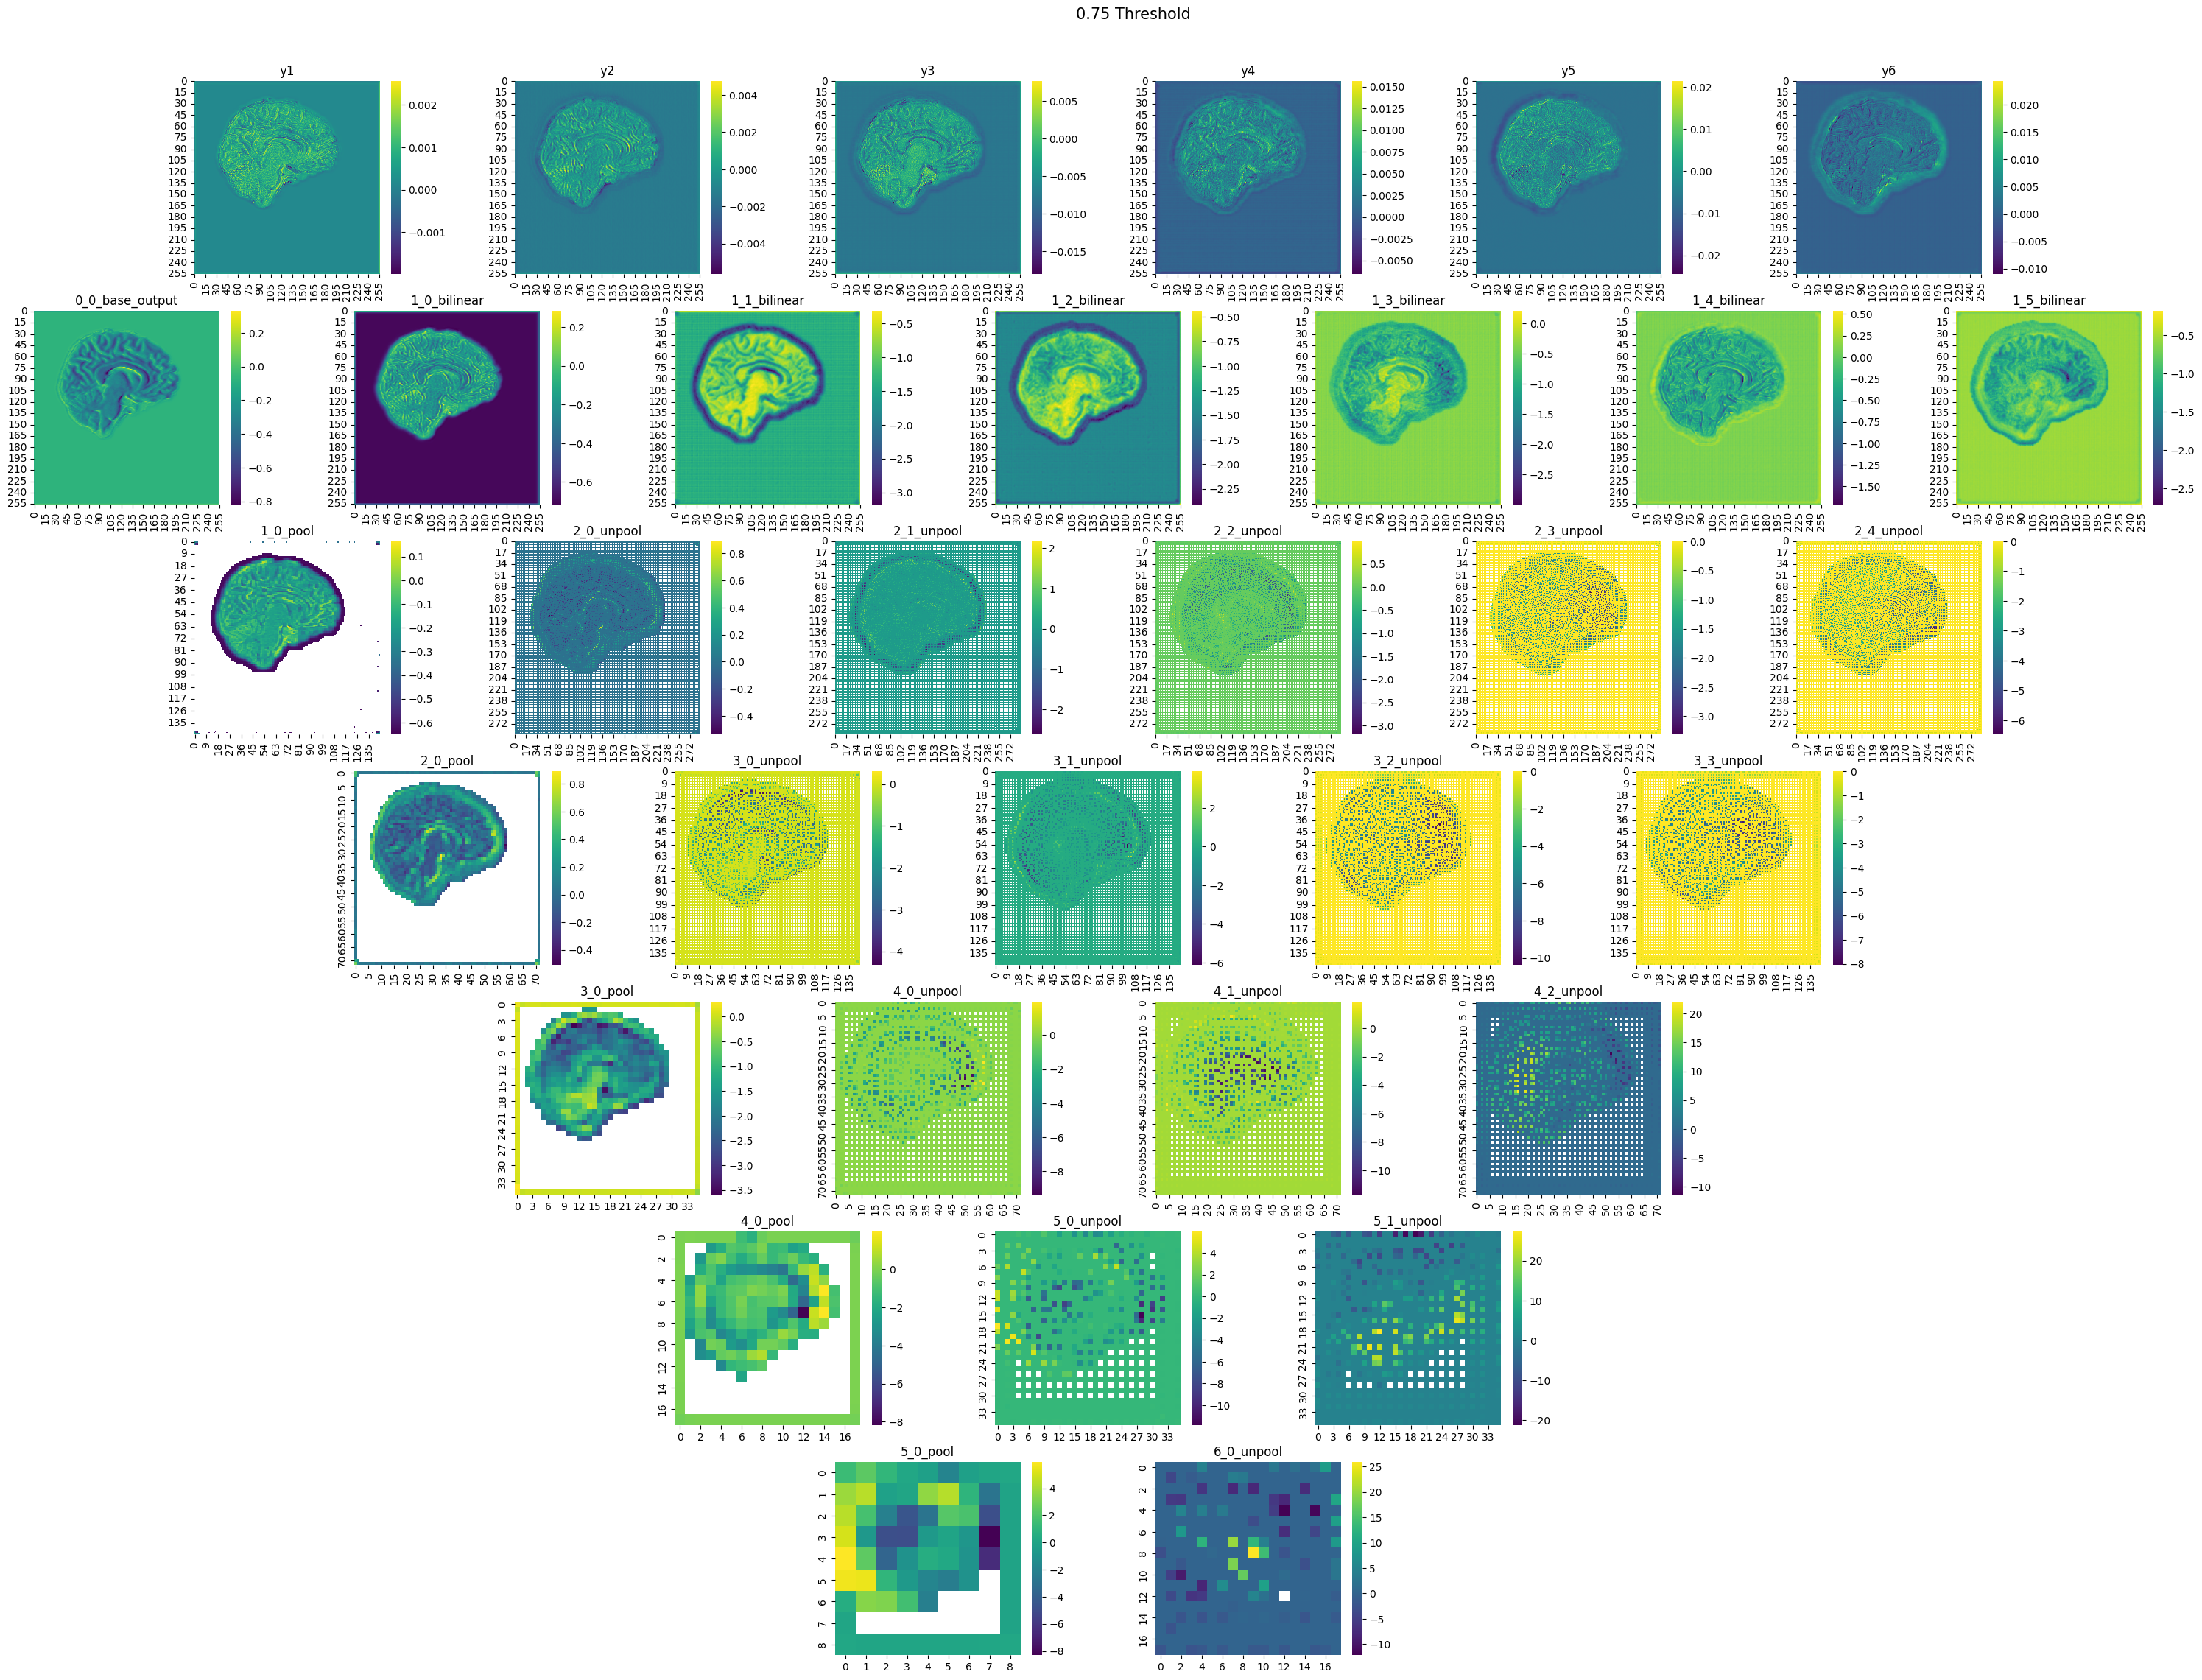

In [22]:
nan_root = '/scratch/vinuyans/skips/embeddings/thresh075/'
cmap = matplotlib.colormaps['viridis'] #.with_extremes(under='white', over='black')    
graph_arch('0.75 Threshold', cmap, nan_root, 'axial', 10)


**Threshold 1 Epsilon 1e-5**

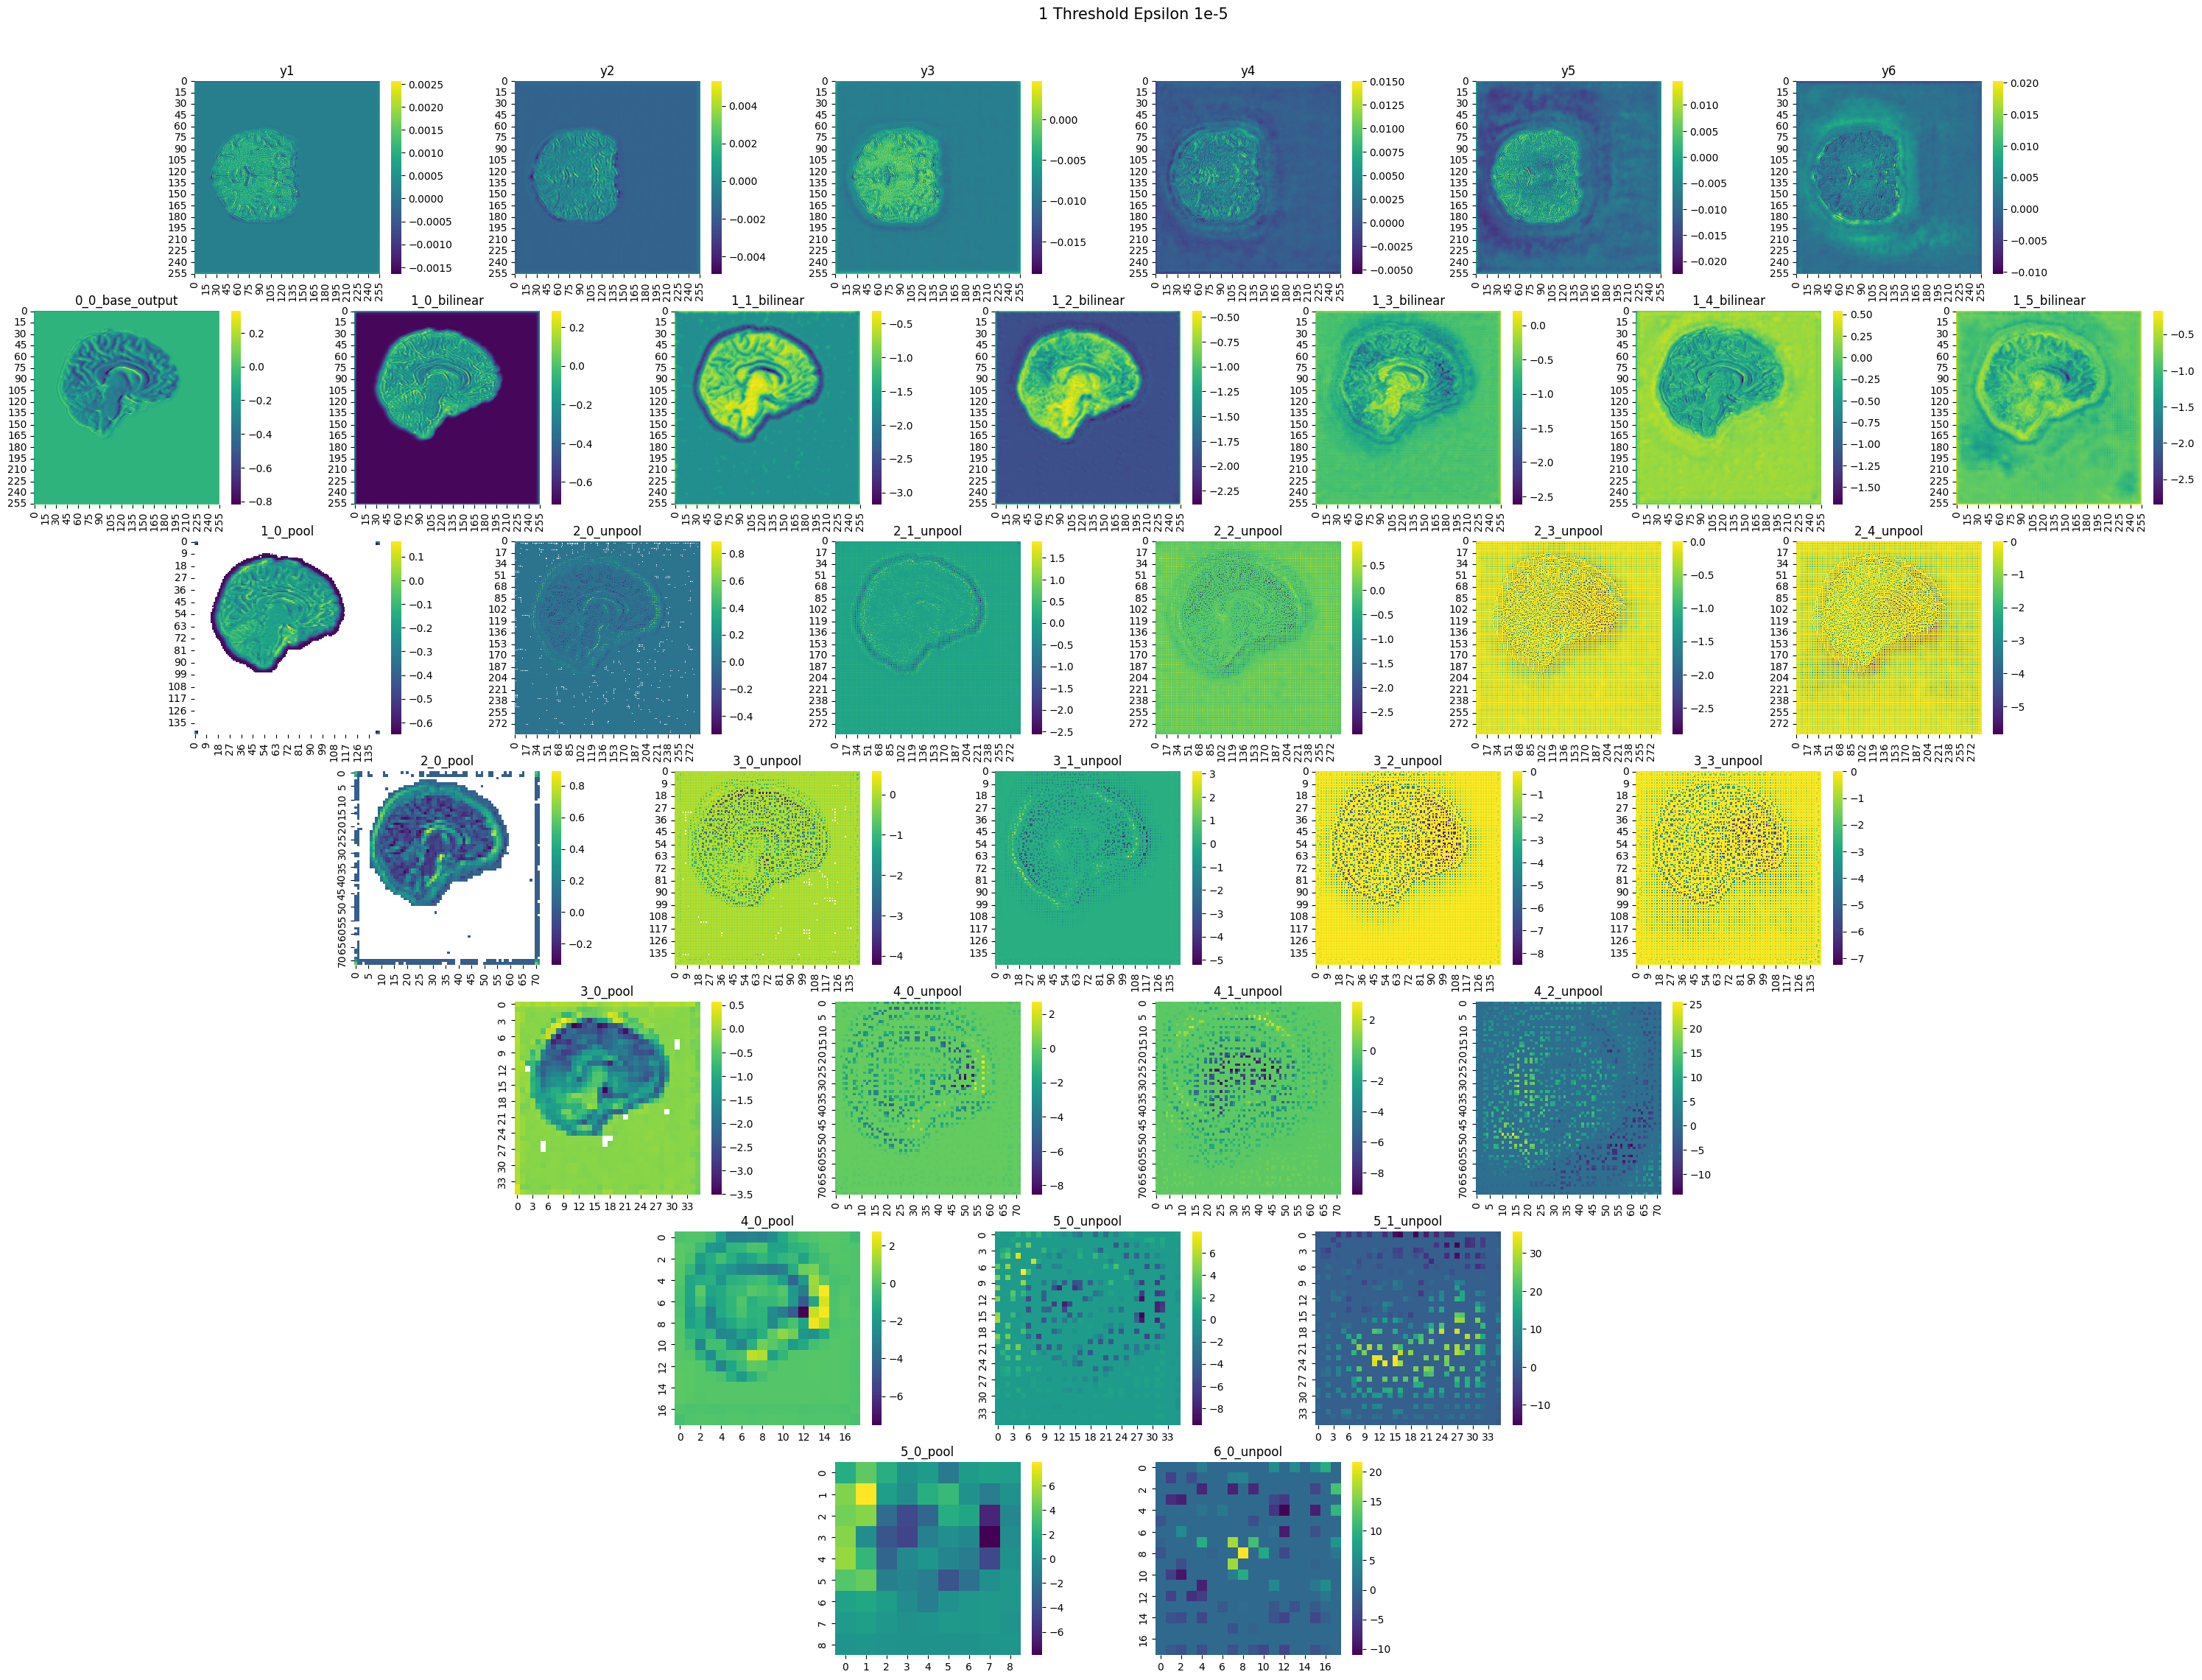

In [21]:
nan_root = '/scratch/vinuyans/skips/embeddings/thresh10/'
cmap = matplotlib.colormaps['viridis'] #.with_extremes(under='white', over='black')    
graph_arch('1 Threshold Epsilon 1e-5', cmap, nan_root, 'axial', 10)

### Experimentation

**VGG Block**
- Input x
- Parametric ReLU (Prelu)
    - ReLU forces all negative values to zero, while PReLU allows some negative values to pass through (with a small negative slope), providing more flexibility in learning patterns in the data.
- Performs conv on Prelu output; obtains x0
- Concatenates and takes the max out of original input and Prelu + conv output; obtains x1_max
- Performs Prelu and another conv on x1_max; obtains x1
- Concatenates and takes the max out of x1 and x1_max; obtains x2_max
- Performs conv on Prelu output; obtains out

**VGG Input Block**
- Input x
- Performs conv; obtains x0
- Performs Prelu + conv; obtains x1
- Concatenates and takes the max out of x0 and x1; obtains x2_max
- Performs Prelu + conv; obtains out


**Model**
- x0_0 = VGGBLockInput 0_0 --> 0_0_base_output
- x0_02 = Interpolation --> 0_0_bilinear
- x1_0 = VGGBlock 1_0 x0_02
- c_max = Concatenate + max out x0_0 and interpolated x1_0 
- x0_1 = VGGBlock 0_1 c_max --> 1_0_bilinear
- pool_x1_0 = Max pooling x1_0 --> 1_0_pool
- x2_0 = VGGBlock 2_0 pool_x1_0
- c2 = Unpool x2_0 --> 2_0_unpool
- c_max = Concatenate + max out x1_0 and c2 --> 1_1_max_input
- x1_1 = VGGBlock 1_1 c_max **DIAGRAMMED UP TO HERE**
- c_3 = interpolated x1_1 --> 1_1_bilinear
- c_max = Concatenate + max out x0_0, x0_1 and c_3
- x0_2 = VGGBlock 0_2 c_max 
- pool_x2_0 = Max pooling x2_0 --> 2_0_pool
- x3_0 = VGGBlock 3_0 pool_x2_0
- c2 = Unpool x3_0 --> 3_0_unpool
- c_max = Concatenate + max out x2_0 and c2 --> 2_1_max_input
- x2_1 = VGGBlock 2_1 c_max 
- c3 = Unpool x2_1 --> 2_1_unpool
- c_max = Concatenate + max out x1_0, x1_1 and c3 --> 1_2_max_input
- x1_2 = VGGBlock 1_2 c_max
- c4 = Interpolated x1_2 --> 1_2_bilinear
- c_max = Concatenate and max out x0_0, x0_1, x0_2 and c4
- x0_3 = VGGBlock 0_3 c_max
- pool_x3_0 = Max pooling x3_0 --> 3_0_pool
- x4_0 = VGGBlock 4_0 pool_x3_0
- c2 = Unpool x4_0 --> 4_0_unpool
- c_max = Concatenate + max out x3_0 and c2 --> 3_1_max_input
- x3_1 = VGGBlock 3_1 c_max
- c3 = Unpool x3_1 --> 3_1_unpool
- c_max = Concatenate + max out x2_0, x2_1 and c3 --> 2_2_max_input
- x2_2 = VGGBlock 2_2 c_max 
- c4 = Unpool x2_2 --> 2_2_unpool
- c_max = Concatenate + max out x1_0, x1_1, x1_2 and c4 --> 1_3_bilinear_max_input
- x1_3 = VGGBlock 1_3 c_max
- c5 = Interpolate x1_3 --> 1_3_bilinear
- c_max = Concatenate + max out x0_0, x0_1, x0_2, x0_3 and c5 --> 1_3_bilinear_max_output
- x0_4 = VGGBlock 0_4 c_max
- pool_x4_0 = Max pooling x4_0 --> 4_0_pool
- x5_0 = VGGBlock 5_0 pool_x4_0
- c2 = Unpool x5_0 --> 5_0_unpool
- c_max = Concatenate + max out x4_0 and c2 
- x4_1 = VGG Block 4_1 c_max
- c3 = Unpool x4_1 --> 4_1_unpool
- c_max = Concatenate + max out x3_0, x3_1 and c3 
- x3_2 = VGGBlock 3_2 c_max 
- c4 = Unpool x3_2 --> 3_2_unpool
- c_max = Concatenate + max out x2_0, x2_1, x2_2 and c4
- x2_3 = VGGBlock 2_3 c_max
- c5 = Unpool x2_3 --> 2_3_unpool
- c_max = Concatenate + max out x1_0, x1_1, x1_2, x1_3 and c5
- x1_4 = VGGBlock 1_4 c_max
- c6 = Interpolate x1_4 --> 1_4_bilinear
- c_max = Concatenate + max out x0_0, x0_1, x0_2, x0_3, x0_4 and c6
- x0_5 = VGGBlock 0_5 c_max
- pool_x5_0 = Max pooling x5_0 --> 5_0_pool
- x6_0 = VGGBlock 6_0 pool_x5_0
- c2 = Unpool x6_0 --> 6_0_unpool
- c_max = Concatenate + max out x5_0 and c2
- x5_1 = VGGBlock 5_1 c_max
- c3 = Unpool x5_1 --> 5_1_unpool
- c_max = Concatenate + max out x4_0, x4_1 and c3
- x4_2 = VGGBlock 4_2 c_max
- c4 = Unpool x4_2
- c_max = Concatenate + max out x3_0, x3_1, x3_2 and c4
- x3_3 = VGGBlock 3_3 c_max
- c5 = Unpool x3_3 --> 3_3_unpool
- c_max = Concatenate + max out x2_0, x2_1, x2_2, x2_3 and c5
- x2_4 = VGGBlock 2_4 c_max
- c6 = Unpool x2_4 --> 2_4_unpool
- c_max = Concatenate + max out x1_0, x1_1, x1_2, x1_3, x1_4 and c6
- x1_5 = VGGBlock 1_5 c_max
- c7 = Interpolate x1_5 --> 1_5_bilinear
- c_max = Concatenate + max out x0_0, x0_1, x0_2, x0_3, x0_4, x0_5 and c7
- x0_6 = VGGBlock 0_6 c_max
- output1 = ( conv x0_1 ) * alpha --> y1
- output2 = ( conv x0_2 ) * alpha --> y2
- output3 = ( conv x0_3 ) * alpha --> y3
- output4 = ( conv x0_4 ) * alpha --> y4
- output5 = ( conv x0_5 ) * alpha --> y5
- output6 = ( conv x0_6 ) * alpha --> y6
- output = (output1 + output2 + output3 + output4 + output5 + output6) / alpha_sum
- denoised = input - output --> denoised

torch.Size([2, 64, 288, 288])
torch.Size([2, 64, 144, 144])
torch.Size([2, 64, 144, 144])


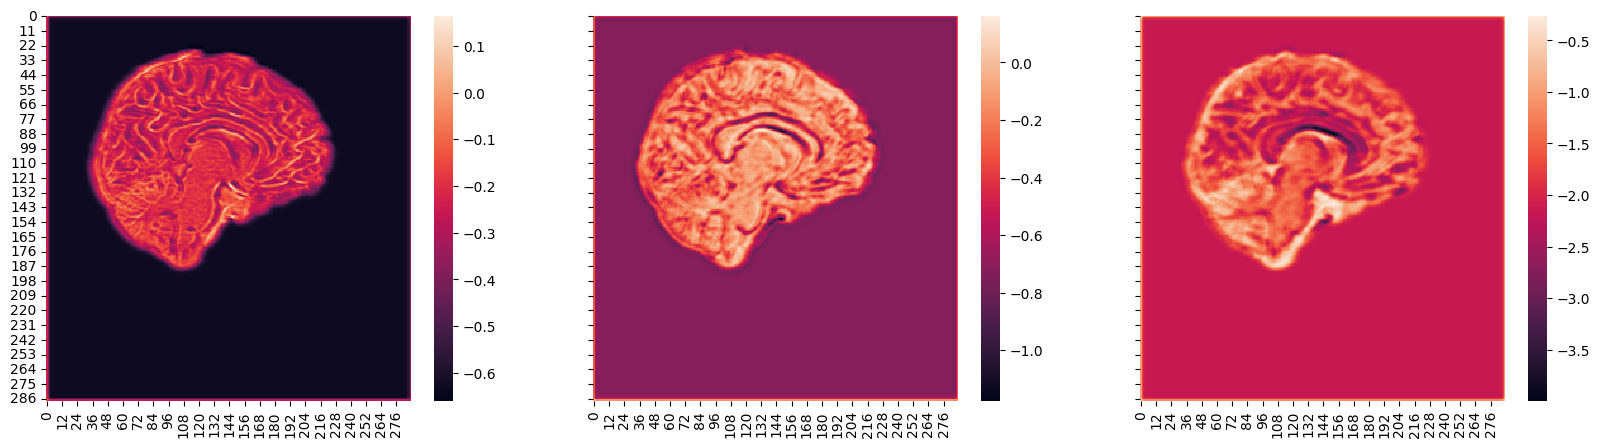

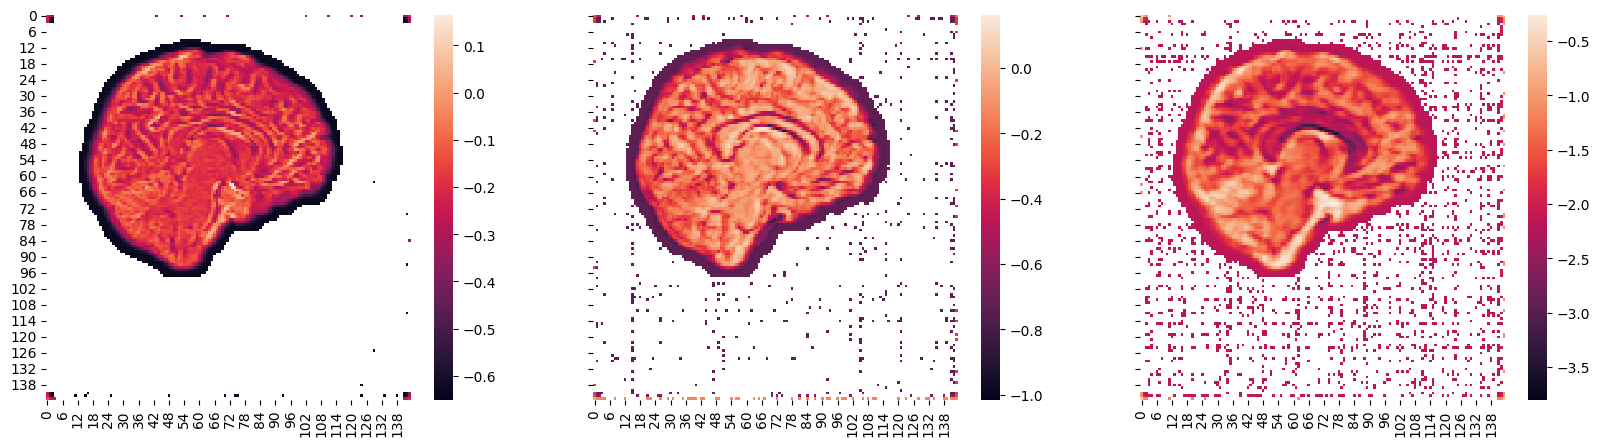

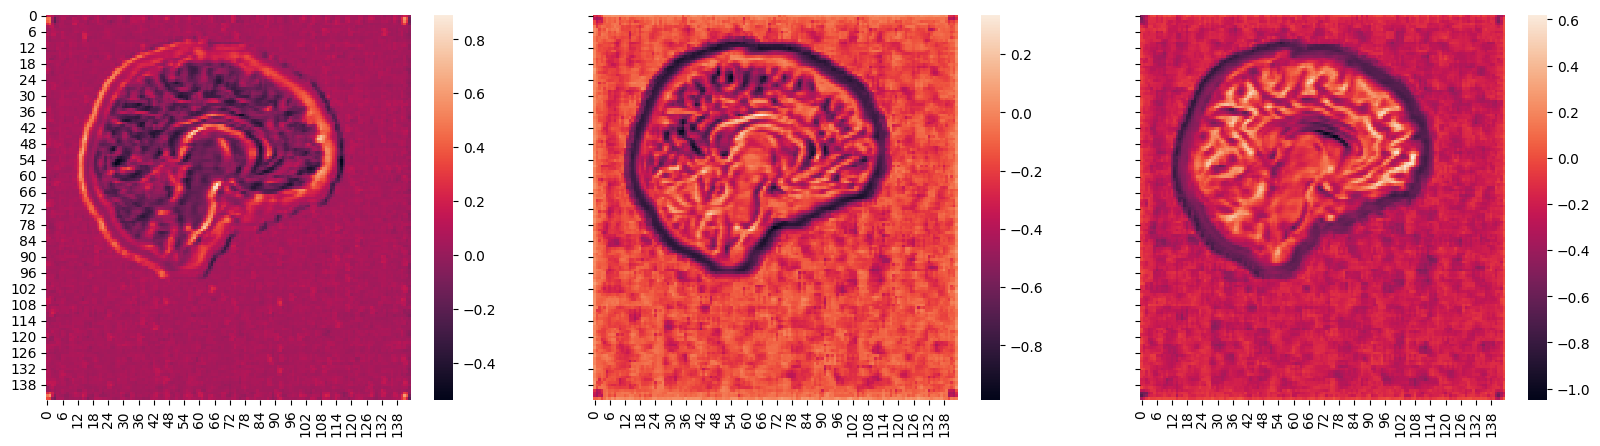

In [96]:
pool_1_0_input = pickle.load(open("/scratch/vinuyans/skips/embeddings/thresh10/axial_1_0_pool_input.pkl", "rb"))
print(pool_1_0_input.shape)

fig, axes = plt.subplots(1, 3, figsize=(20,5), sharey=True)
sns.heatmap(pool_1_0_input[0,10], ax=axes[0])
sns.heatmap(pool_1_0_input[0,30], ax=axes[1])
sns.heatmap(pool_1_0_input[0,50], ax=axes[2])

embed_1_0_bilinear = pickle.load(open("/scratch/vinuyans/skips/embeddings/thresh10/axial_1_0_pool.pkl", "rb"))
print(embed_1_0_bilinear.shape)

fig, axes = plt.subplots(1, 3, figsize=(20,5), sharey=True)
sns.heatmap(embed_1_0_bilinear[0,10], ax=axes[0])
sns.heatmap(embed_1_0_bilinear[0,30], ax=axes[1])
sns.heatmap(embed_1_0_bilinear[0,50], ax=axes[2])


embed_1_0_bilinear = pickle.load(open("/scratch/vinuyans/skips/embeddings/thresh10/axial_2_0_pool.pkl", "rb"))
print(embed_1_0_bilinear.shape)

fig, axes = plt.subplots(1, 3, figsize=(20,5), sharey=True)
sns.heatmap(embed_1_0_bilinear[0,10], ax=axes[0])
sns.heatmap(embed_1_0_bilinear[0,30], ax=axes[1])
sns.heatmap(embed_1_0_bilinear[0,50], ax=axes[2]);

torch.Size([2, 64, 288, 288])


<Axes: >

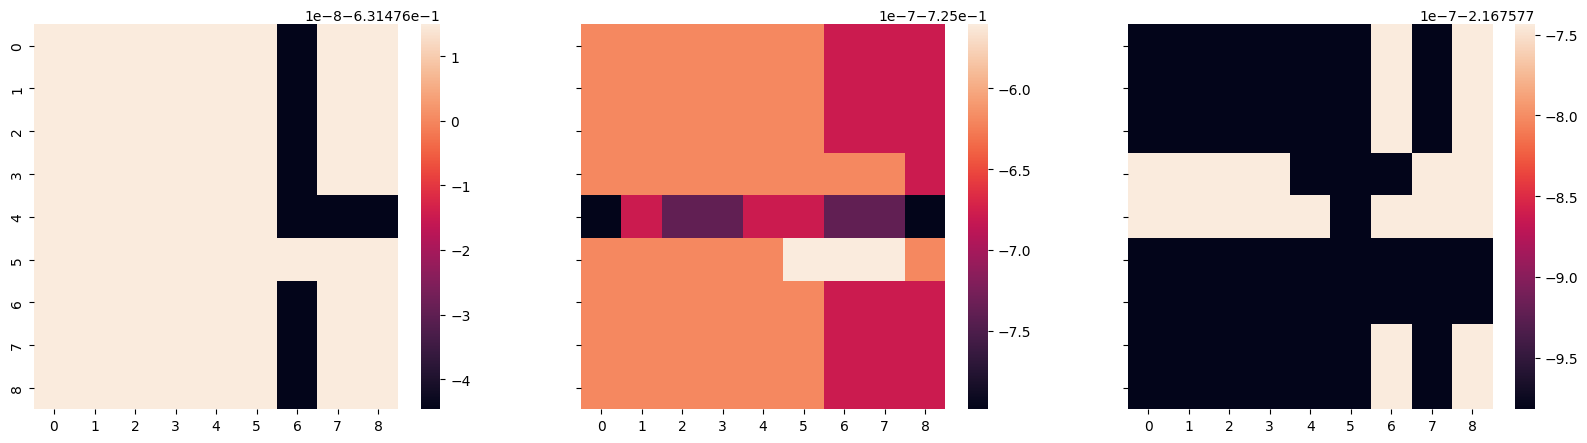

In [94]:
pool_1_0_input = pickle.load(open("/scratch/vinuyans/skips/embeddings/thresh10/axial_1_0_pool_input.pkl", "rb"))
print(pool_1_0_input.shape)

fig, axes = plt.subplots(1, 3, figsize=(20,5), sharey=True)
sns.heatmap(pool_1_0_input[0,10, 9:18, 9:18], ax=axes[0], )
sns.heatmap(pool_1_0_input[0,30, 9:18, 9:18], ax=axes[1], )
sns.heatmap(pool_1_0_input[0,50, 9:18, 9:18], ax=axes[2], )

In [18]:
print(len(set(pool_1_0_input[0,10, :50, :50].ravel().numpy())), pool_1_0_input[0,10, :50, :50].numel())
print(len(set(pool_1_0_input[0,30, :50, :50].ravel().numpy())), pool_1_0_input[0,30, :50, :50].numel())
print(len(set(pool_1_0_input[0,50, :50, :50].ravel().numpy())), pool_1_0_input[0,50, :50, :50].numel())

76 2500
97 2500
67 2500


torch.Size([1, 1, 25, 25])


<Axes: >

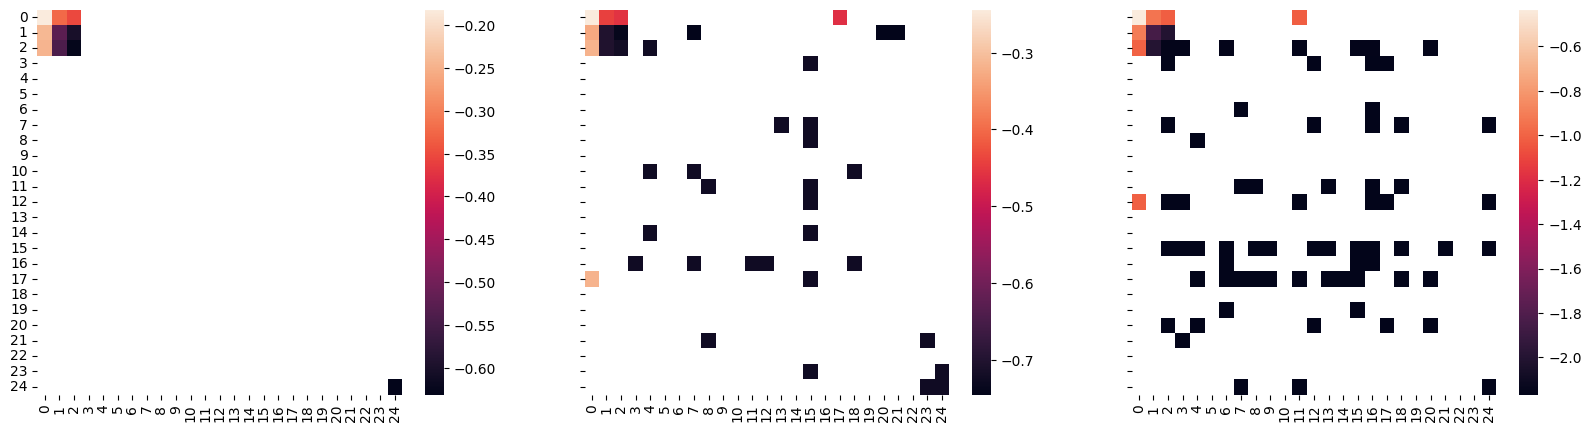

In [21]:
fig, axes = plt.subplots(1, 3, figsize=(20,5), sharey=True)

pool_x1_0, indices_x1 = NaNPool2d()(pool_1_0_input[:1, 10:11, :50, :50], (2, 2), (2, 2))
print(pool_x1_0.shape)

sns.heatmap(pool_x1_0.squeeze(), ax=axes[0])
pool_x1_0, indices_x1 = NaNPool2d()(pool_1_0_input[:1, 30:31, :50, :50], (2, 2), (2, 2))

sns.heatmap(pool_x1_0.squeeze(), ax=axes[1])

pool_x1_0, indices_x1 = NaNPool2d()(pool_1_0_input[:1, 50:51, :50, :50], (2, 2), (2, 2))
sns.heatmap(pool_x1_0.squeeze(), ax=axes[2])


**Apply NaNPooling and Convolution Across Different Thresholds**

In [5]:
# pool_x1_0, indices_x1 = NaNPool2d()(embed_1_0_bilinear[:1, 9:10, :50, :50], (2, 2), (2, 2))
pool_x1_0, indices_x1 = NaNPool2d()(pool_1_0_input[:1, 9:10, :50, :50], (2, 2), (2, 2))

conv0 = NaNConv2d(train=False,threshold=0.75, kernel=torch.randn((1,1,3,3)), stride=1, padding=1)(pool_x1_0)

print('Pooling shape', pool_x1_0.shape)
print('Conv shape', conv0.shape)


Pooling shape torch.Size([1, 1, 25, 25])
Conv shape torch.Size([1, 1, 25, 25])


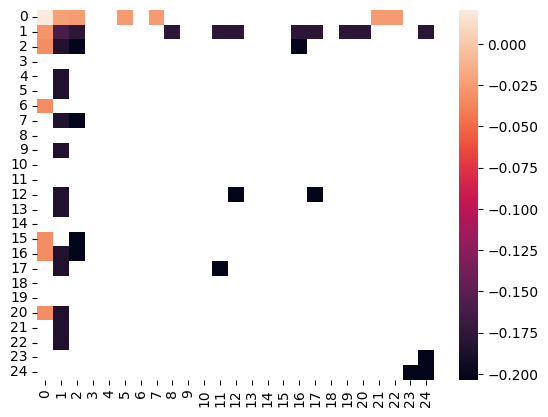

<Axes: >

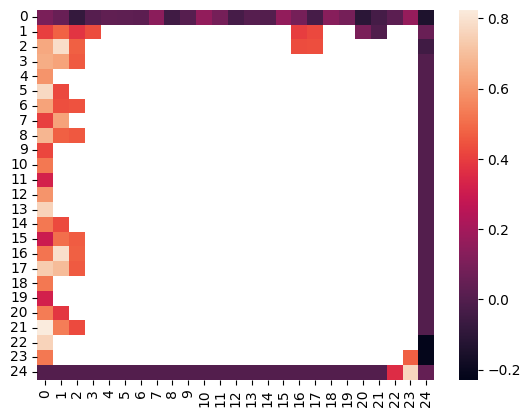

In [7]:
sns.heatmap(pool_x1_0.squeeze());
plt.show()


sns.heatmap(conv0.squeeze())



<Axes: >

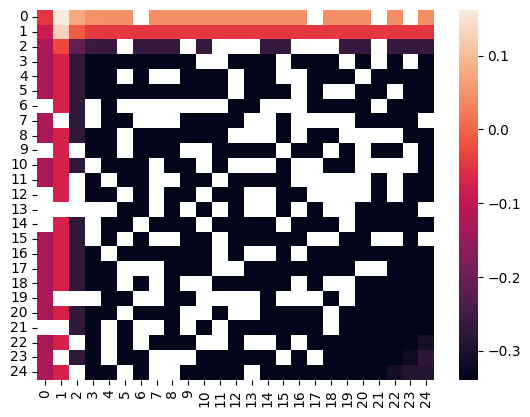

In [22]:
sns.heatmap(pool_x1_0.squeeze());


<Axes: >

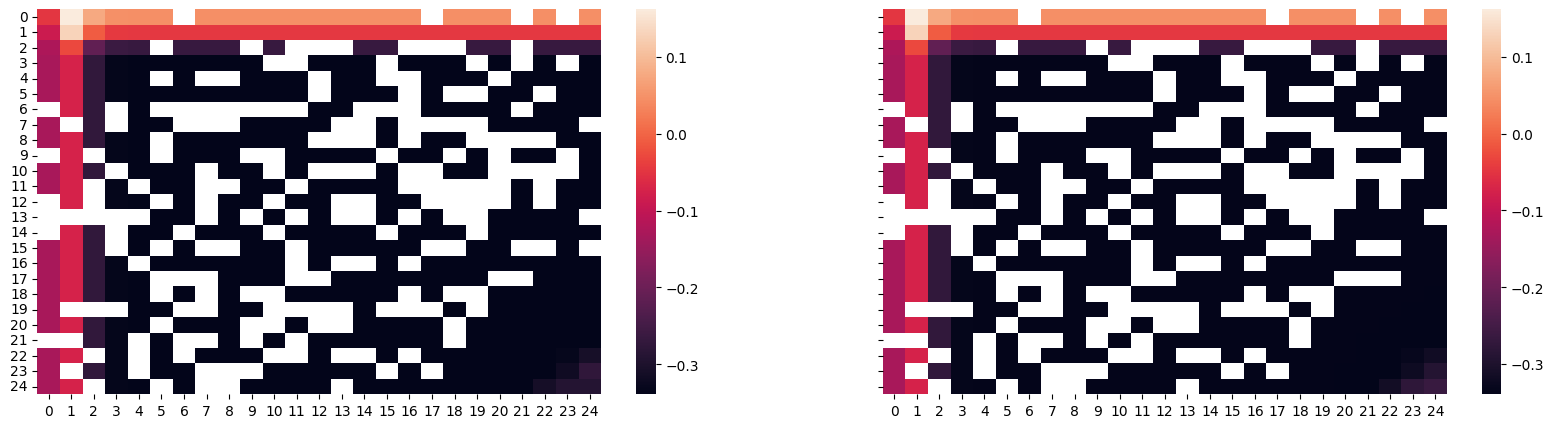

In [24]:
fig, axes = plt.subplots(1, 2, figsize=(20,5), sharey=True)

sns.heatmap(pool_x1_0.squeeze()[0], ax=axes[0])
sns.heatmap(pool_x1_0.squeeze()[1], ax=axes[1])


Threshold 0.75

<Axes: >

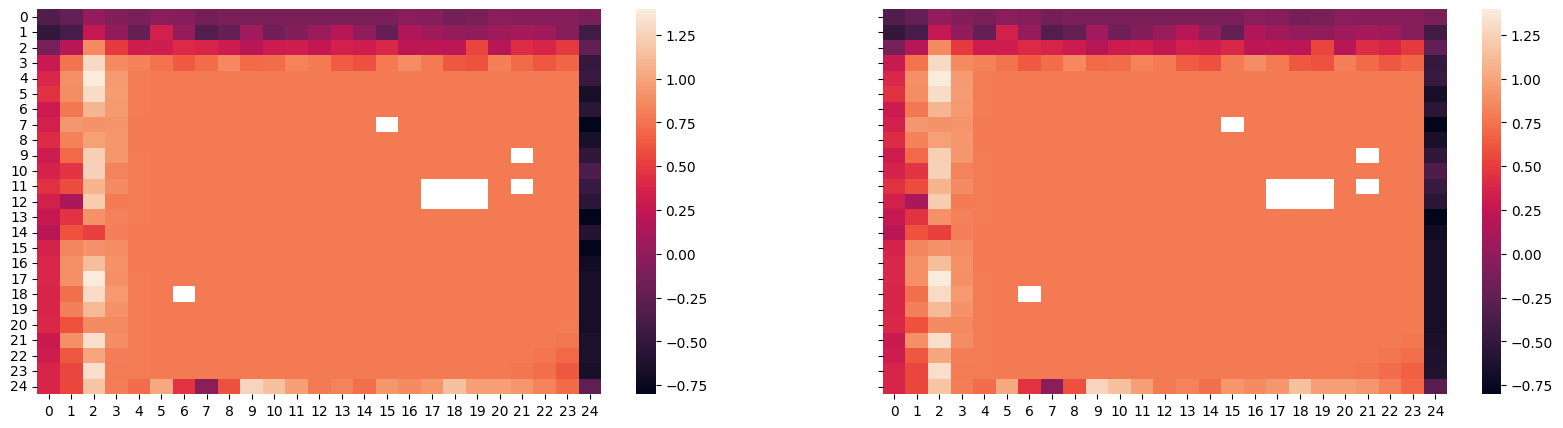

In [46]:
fig, axes = plt.subplots(1, 2, figsize=(20,5), sharey=True)

sns.heatmap(conv0.squeeze()[0], ax=axes[0])
sns.heatmap(conv0.squeeze()[1], ax=axes[1])


Threshold 1

<Axes: >

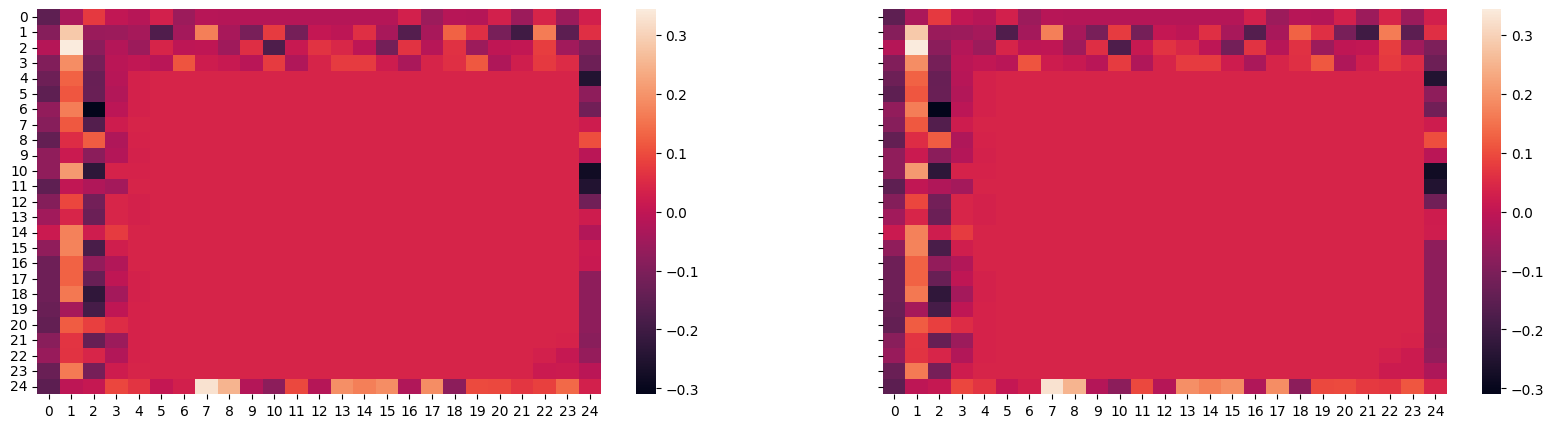

In [36]:
fig, axes = plt.subplots(1, 2, figsize=(20,5), sharey=True)

sns.heatmap(conv0.squeeze()[0], ax=axes[0])
sns.heatmap(conv0.squeeze()[1], ax=axes[1])


torch.Size([2, 64, 36, 36])
torch.Size([2, 64, 36, 36])


<Axes: >

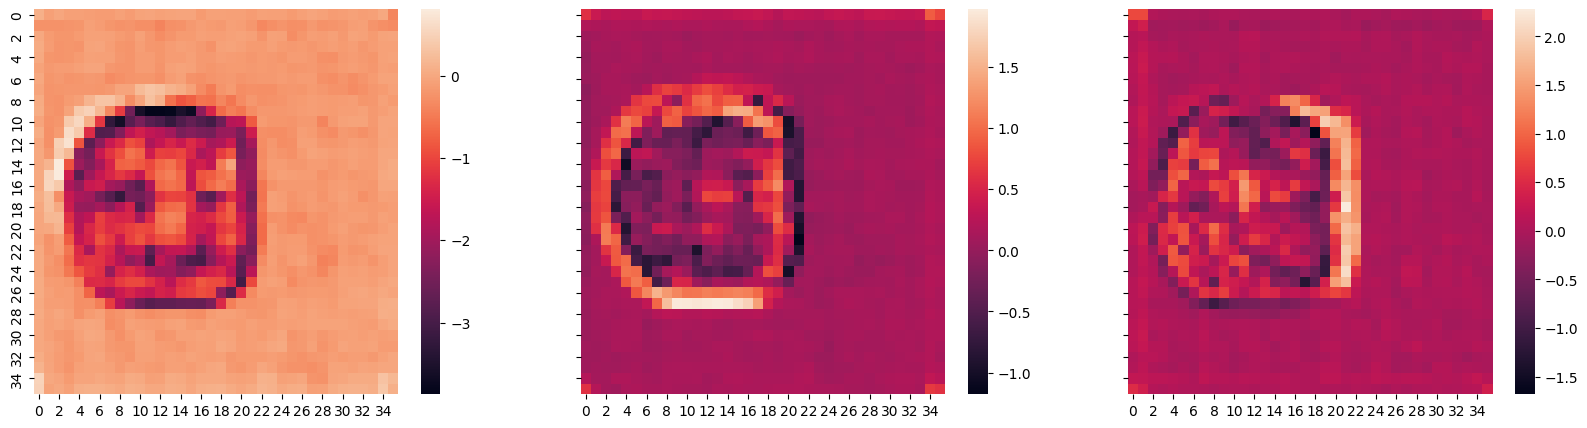

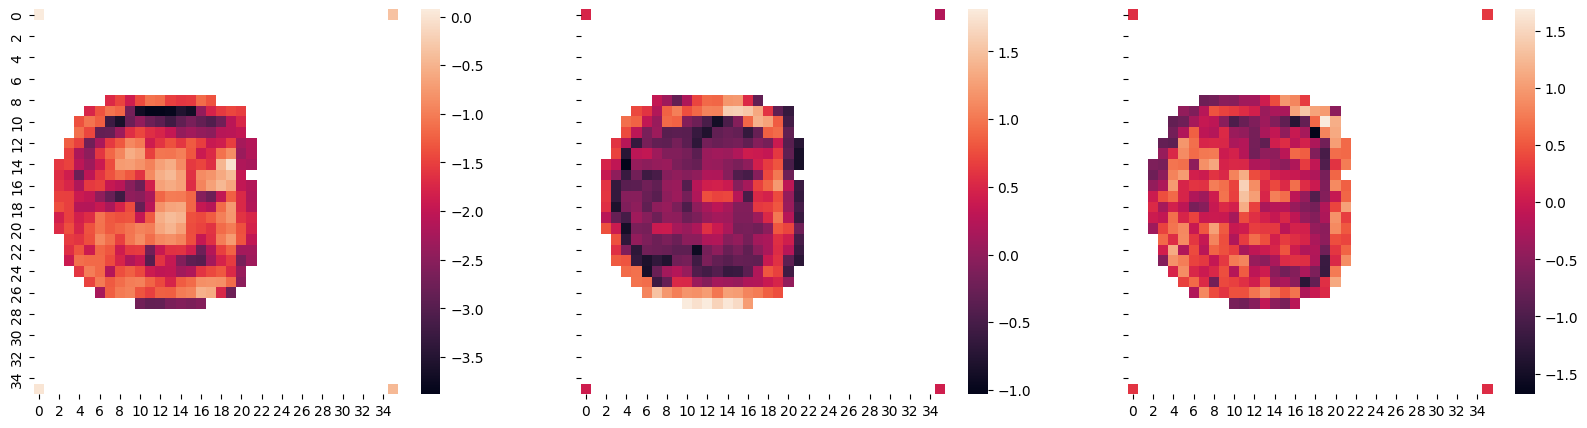

In [14]:
block_order = ['0_0', '1_0', '2_0', '3_0', '4_0', '5_0', '6_0',
               '0_1', '1_1', '2_1', '3_1', '4_1', '5_1',
               '0_2', '1_2', '2_2', '3_2', '4_2',
               '0_3', '1_3', '2_3', '3_3',
               '0_4', '1_4', '2_4',
               '0_5', '1_5',
               '0_6']


"""coronal_0_0_base_output.pkl          coronal_3_0_pool.pkl
coronal_0_0_bilinear.pkl             coronal_3_0_unpool.pkl
coronal_1_0_bilinear_v2.pkl          coronal_3_1_max_input.pkl
coronal_1_0_pool_indices.pkl         coronal_3_1_unpool.pkl
coronal_1_0_pool.pkl                 coronal_3_2_unpool.pkl
coronal_1_1_bilinear.pkl             coronal_3_3_unpool.pkl
coronal_1_1_max_input.pkl            coronal_4_0_pool_indices.pkl
coronal_1_2_bilinear.pkl             coronal_4_0_pool.pkl
coronal_1_2_max_input.pkl            coronal_4_0_unpool.pkl
coronal_1_3_bilinear_max_input.pkl   coronal_4_1_unpool.pkl
coronal_1_3_bilinear_max_output.pkl  coronal_4_2_unpool.pkl
coronal_1_3_bilinear.pkl             coronal_5_0_pool_indices.pkl
coronal_1_4_bilinear.pkl             coronal_5_0_pool.pkl
coronal_1_5_bilinear.pkl             coronal_5_0_unpool.pkl
coronal_2_0_pool_indices.pkl         coronal_5_1_unpool.pkl
coronal_2_0_pool.pkl                 coronal_6_0_unpool.pkl
coronal_2_0_unpool.pkl               coronal_denoised.pkl
coronal_2_1_max_input.pkl            coronal_y1.pkl
coronal_2_1_unpool.pkl               coronal_y2.pkl
coronal_2_2_max_input.pkl            coronal_y3.pkl
coronal_2_2_unpool.pkl               coronal_y4.pkl
coronal_2_3_unpool.pkl               coronal_y5.pkl
coronal_2_4_unpool.pkl               coronal_y6.pkl
coronal_3_0_pool_indices.pkl """

embed_1_0_bilinear = pickle.load(open(f"/scratch/vinuyans/skips/embeddings/thresh10/3_0_pool.pkl", "rb"))
print(embed_1_0_bilinear.shape)

fig, axes = plt.subplots(1, 3, figsize=(20,5), sharey=True)
sns.heatmap(embed_1_0_bilinear[0,10, :50, :50], ax=axes[0])
sns.heatmap(embed_1_0_bilinear[0,30], ax=axes[1])
sns.heatmap(embed_1_0_bilinear[0,50], ax=axes[2])


embed_1_0_bilinear = pickle.load(open(f"/scratch/vinuyans/skips/embeddings/thresh05/3_0_pool.pkl", "rb"))
print(embed_1_0_bilinear.shape)

fig, axes = plt.subplots(1, 3, figsize=(20,5), sharey=True)
sns.heatmap(embed_1_0_bilinear[0,10, :50, :50], ax=axes[0])
sns.heatmap(embed_1_0_bilinear[0,30], ax=axes[1])
sns.heatmap(embed_1_0_bilinear[0,50], ax=axes[2])


In [6]:
from nan_ops import NaNPool2d

# def __init__(self, max_threshold: int = 1, probabilistic: bool = False, nan_probability: Optional[float] = 0.8):

pool_x1_0, indices_x1 = NaNPool2d()(embed_1_0_bilinear[:1, 8:10], (2, 2), (2, 2))

pool_x1_0.shape

torch.Size([1, 2, 128, 128])

<Axes: >

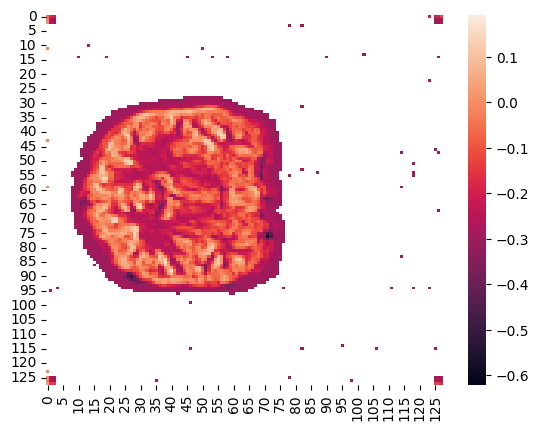

In [7]:
# fig, axes = plt.subplots(1, 3, figsize=(20,5), sharey=True)
sns.heatmap(pool_x1_0.squeeze()[0])
# sns.heatmap(embed_1_0_bilinear[0,30], ax=axes[1])
# sns.heatmap(embed_1_0_bilinear[0,50], ax=axes[2])

## SkipConv

In [7]:
def count_skipped_ops(filename):
    

    f = open(filename, 'r')
#     print(filename)

    skip_count = {}

    for line in f: 
        
        line = line.strip()
        if 'model loaded' in line:
               if line.split('model loaded')[0].strip() == 'First':
                    axis = 'axial'
                    skip_count[axis] = {}
               elif line.split('model loaded')[0].strip() == 'Second':
                  axis = 'coronal'
                  skip_count[axis] = {}
               elif line.split('model loaded')[0].strip() == 'Third':
                  axis = 'sagittal'
                  skip_count[axis] = {}    
          # views = {'First': 'axial', 'Second': 'coronal', 'Third': 'sagittal'}
        
        # Regex pattern
        pattern = r'(?:\d{1,2} \w{3}  \d{1,2} \d{2}:\d{2}:\d{2} \d{4}, )?(\d+_\d+): Conv1: (\d+)/(\d+), Conv2: (\d+)/(\d+), Conv3: (\d+)/(\d+)'
        
        match = re.search(pattern, line)
        if match:
          key = match.group(1)
          # if key == '6_0': print('here')
          skip_count[axis][key] = {
               'Conv1': int(match.group(2))/int(match.group(3)),
               'Conv2': int(match.group(4))/int(match.group(5)),
               'Conv3': int(match.group(6))/int(match.group(7))
          }
     
    return skip_count


block_order = ['0_0', '1_0', '2_0', '3_0', '4_0', '5_0', '6_0',
               '0_1', '1_1', '2_1', '3_1', '4_1', '5_1',
               '0_2', '1_2', '2_2', '3_2', '4_2',
               '0_3', '1_3', '2_3', '3_3',
               '0_4', '1_4', '2_4',
               '0_5', '1_5',
               '0_6']

# block_order = ['0_0',
#                '0_1', '1_0',
#                '0_2', '1_1', '2_0',
#                '0_3', '1_2', '2_1', '3_0',
#                '0_4', '1_3', '2_2', '3_1', '4_0',
#                '0_5', '1_4', '2_3', '3_2', '4_1', '5_0',
#                '0_6', '1_5', '2_4', '3_3', '4_2', '5_1', '6_0']

def aggregate_per_threshold(thresh, thresh_sub):

    sub_ratio = {thresh: {'coronal': {}, 'axial': {}, 'sagittal': {}} }


    for num, slice in enumerate(thresh_sub):
        # print(plane)
        # sub_ratio[:] = {}

        for plane in slice:

            sub_ratio[thresh][plane][num] = []

            # print(sub[plane])

            for block in block_order:
                sub_ratio[thresh][plane][num].append(np.mean(list(slice[plane][block].values())))
        
    return sub_ratio



# _ = count_skipped_ops(f"/scratch/vinuyans/skips/slurm/t1_{5}.out")


### Experimenting Across Epsilons

**Threshold 0.75 Epsilon=1e-7**

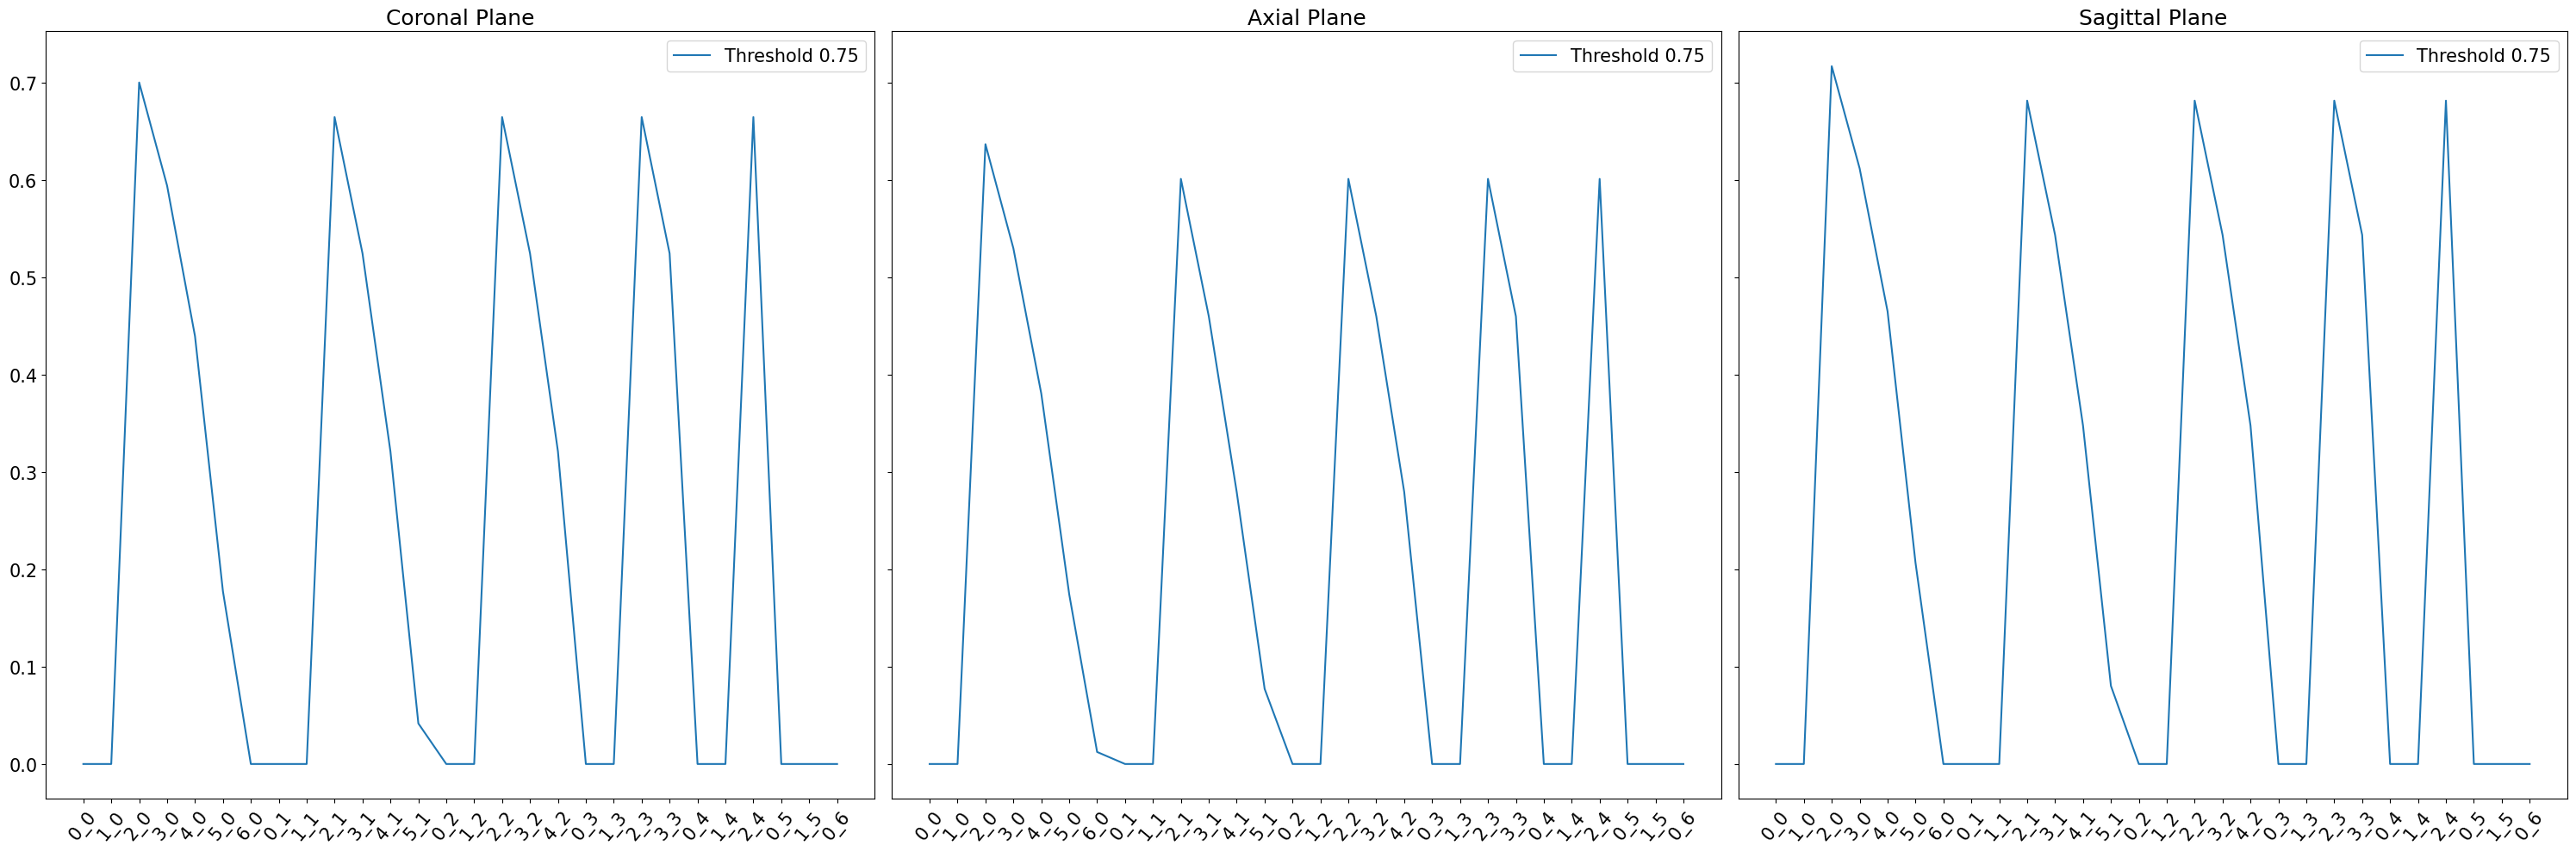

In [11]:
thresh075_sub = count_skipped_ops(f"/scratch/vinuyans/skips/slurm/t0.75_sub-0003002_embedding.out")

sub_ratio={}


# sub_ratio.update(aggregate_per_threshold('1', thresh1_sub))
sub_ratio.update(aggregate_per_threshold('0.75', [thresh075_sub]))


fig, axes = plt.subplots(1, 3, figsize=(30,10), sharey=True)

for num, plane in enumerate(['coronal', 'axial', 'sagittal']):
# for num, plane in enumerate(['axial']):

    for thresh in ['0.75']:

        subs = np.array(list(sub_ratio[thresh][plane].values()))

        avg = np.mean( np.array(list(sub_ratio[thresh][plane].values())), axis=0)
        stdev = np.std( np.array(list(sub_ratio[thresh][plane].values())), axis=0)

        axes[num].plot(avg, label=f'Threshold {thresh}')
        axes[num].fill_between(range(len(avg)), avg - stdev, avg + stdev, alpha=0.3)
        # axes[num].set_ylim(-0.1,1)
        axes[num].set_title(f'{plane.title()} Plane', fontsize=18)
        axes[num].legend(fontsize=15)
        axes[num].set_xticks(np.arange(len(avg)), block_order, rotation=50, fontsize=13)
        axes[num].tick_params(axis='x', labelsize=15)  
        axes[num].tick_params(axis='y', labelsize=15)

plt.tight_layout()


**Threshold 0.75 Epsilon=1e-6**

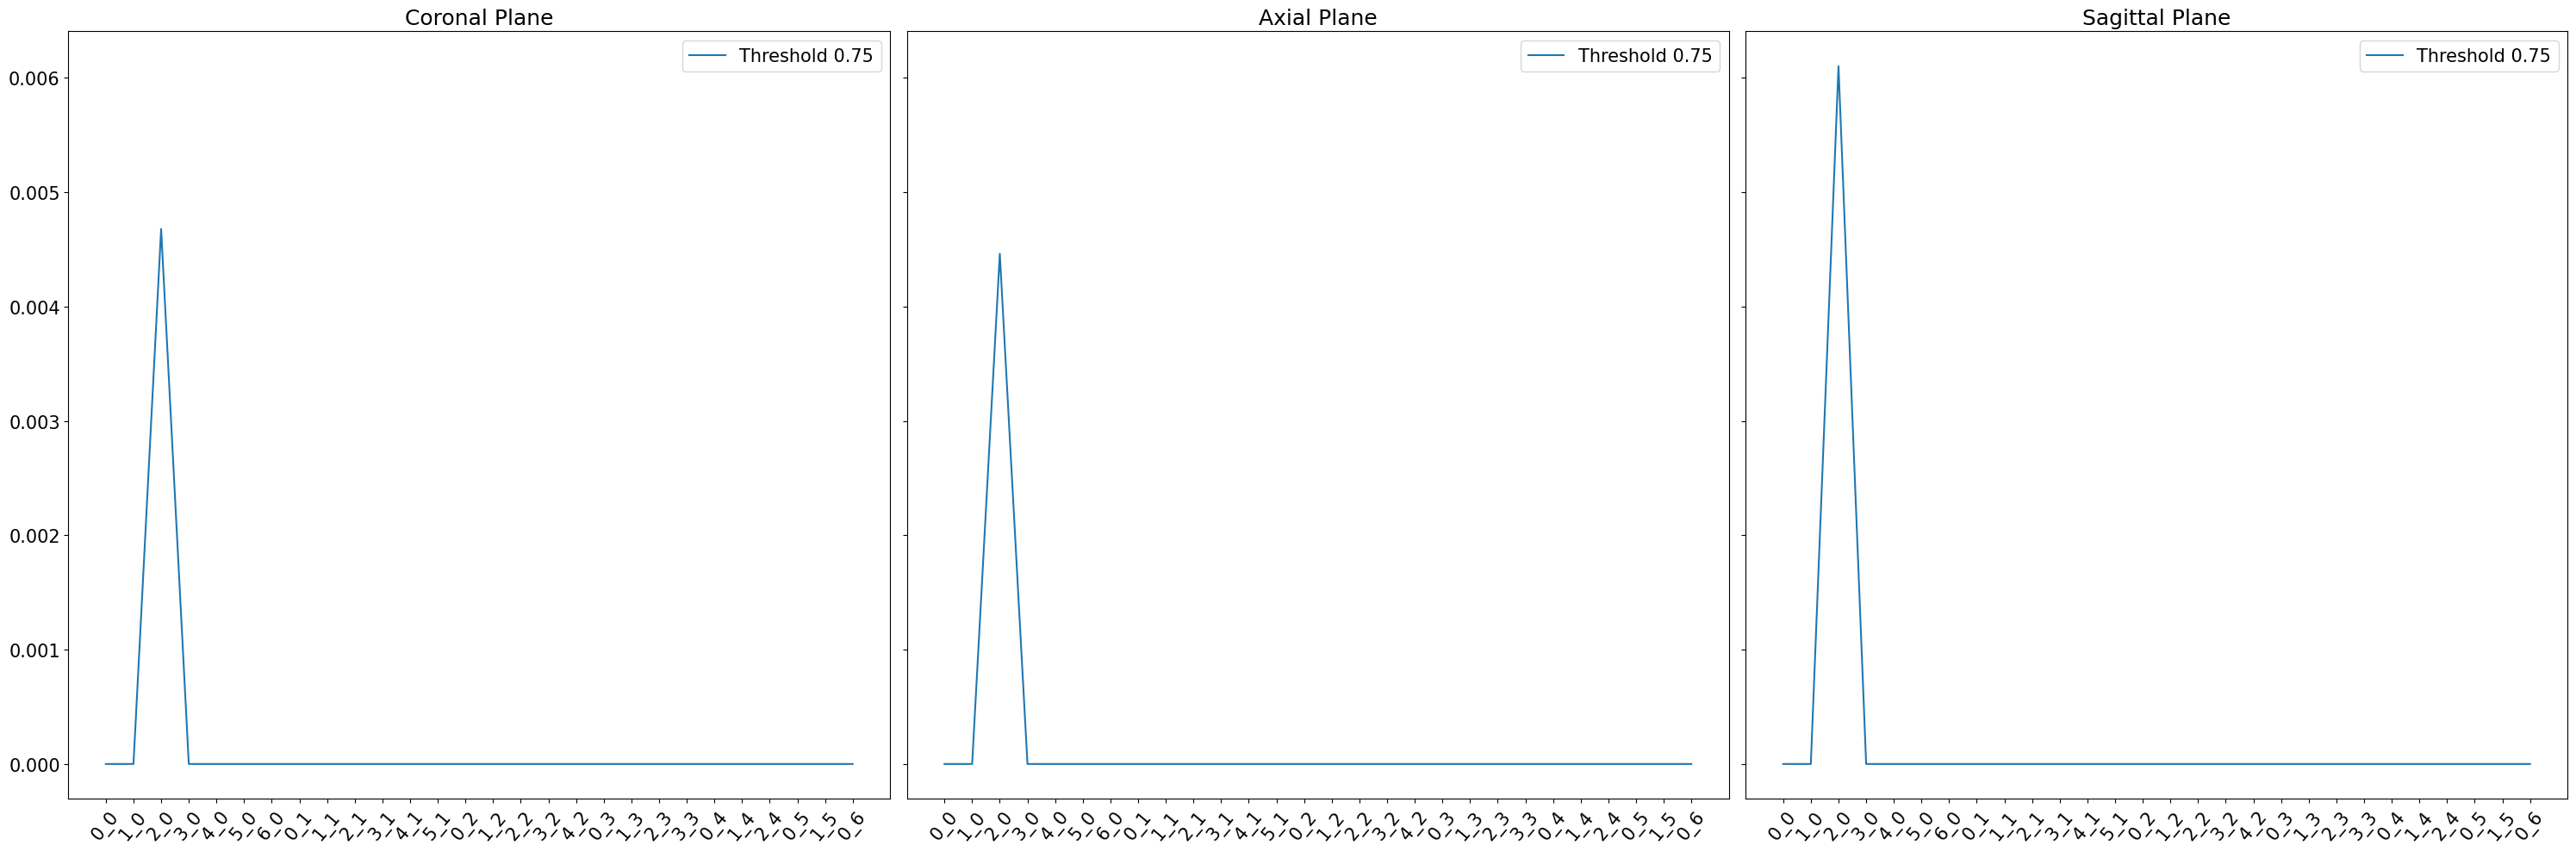

In [5]:
thresh075_sub = count_skipped_ops(f"/scratch/vinuyans/skips/slurm/t1.0_sub-0003002_60_ep1e-6.out")

sub_ratio={}


# sub_ratio.update(aggregate_per_threshold('1', thresh1_sub))
sub_ratio.update(aggregate_per_threshold('0.75', [thresh075_sub]))


fig, axes = plt.subplots(1, 3, figsize=(30,10), sharey=True)

for num, plane in enumerate(['coronal', 'axial', 'sagittal']):
# for num, plane in enumerate(['axial']):

    for thresh in ['0.75']:

        subs = np.array(list(sub_ratio[thresh][plane].values()))

        avg = np.mean( np.array(list(sub_ratio[thresh][plane].values())), axis=0)
        stdev = np.std( np.array(list(sub_ratio[thresh][plane].values())), axis=0)

        axes[num].plot(avg, label=f'Threshold {thresh}')
        axes[num].fill_between(range(len(avg)), avg - stdev, avg + stdev, alpha=0.3)
        # axes[num].set_ylim(-0.1,1)
        axes[num].set_title(f'{plane.title()} Plane', fontsize=18)
        axes[num].legend(fontsize=15)
        axes[num].set_xticks(np.arange(len(avg)), block_order, rotation=50, fontsize=13)
        axes[num].tick_params(axis='x', labelsize=15)  
        axes[num].tick_params(axis='y', labelsize=15)

plt.tight_layout()


**Threshold 0.75 Epsilon=1e-5**

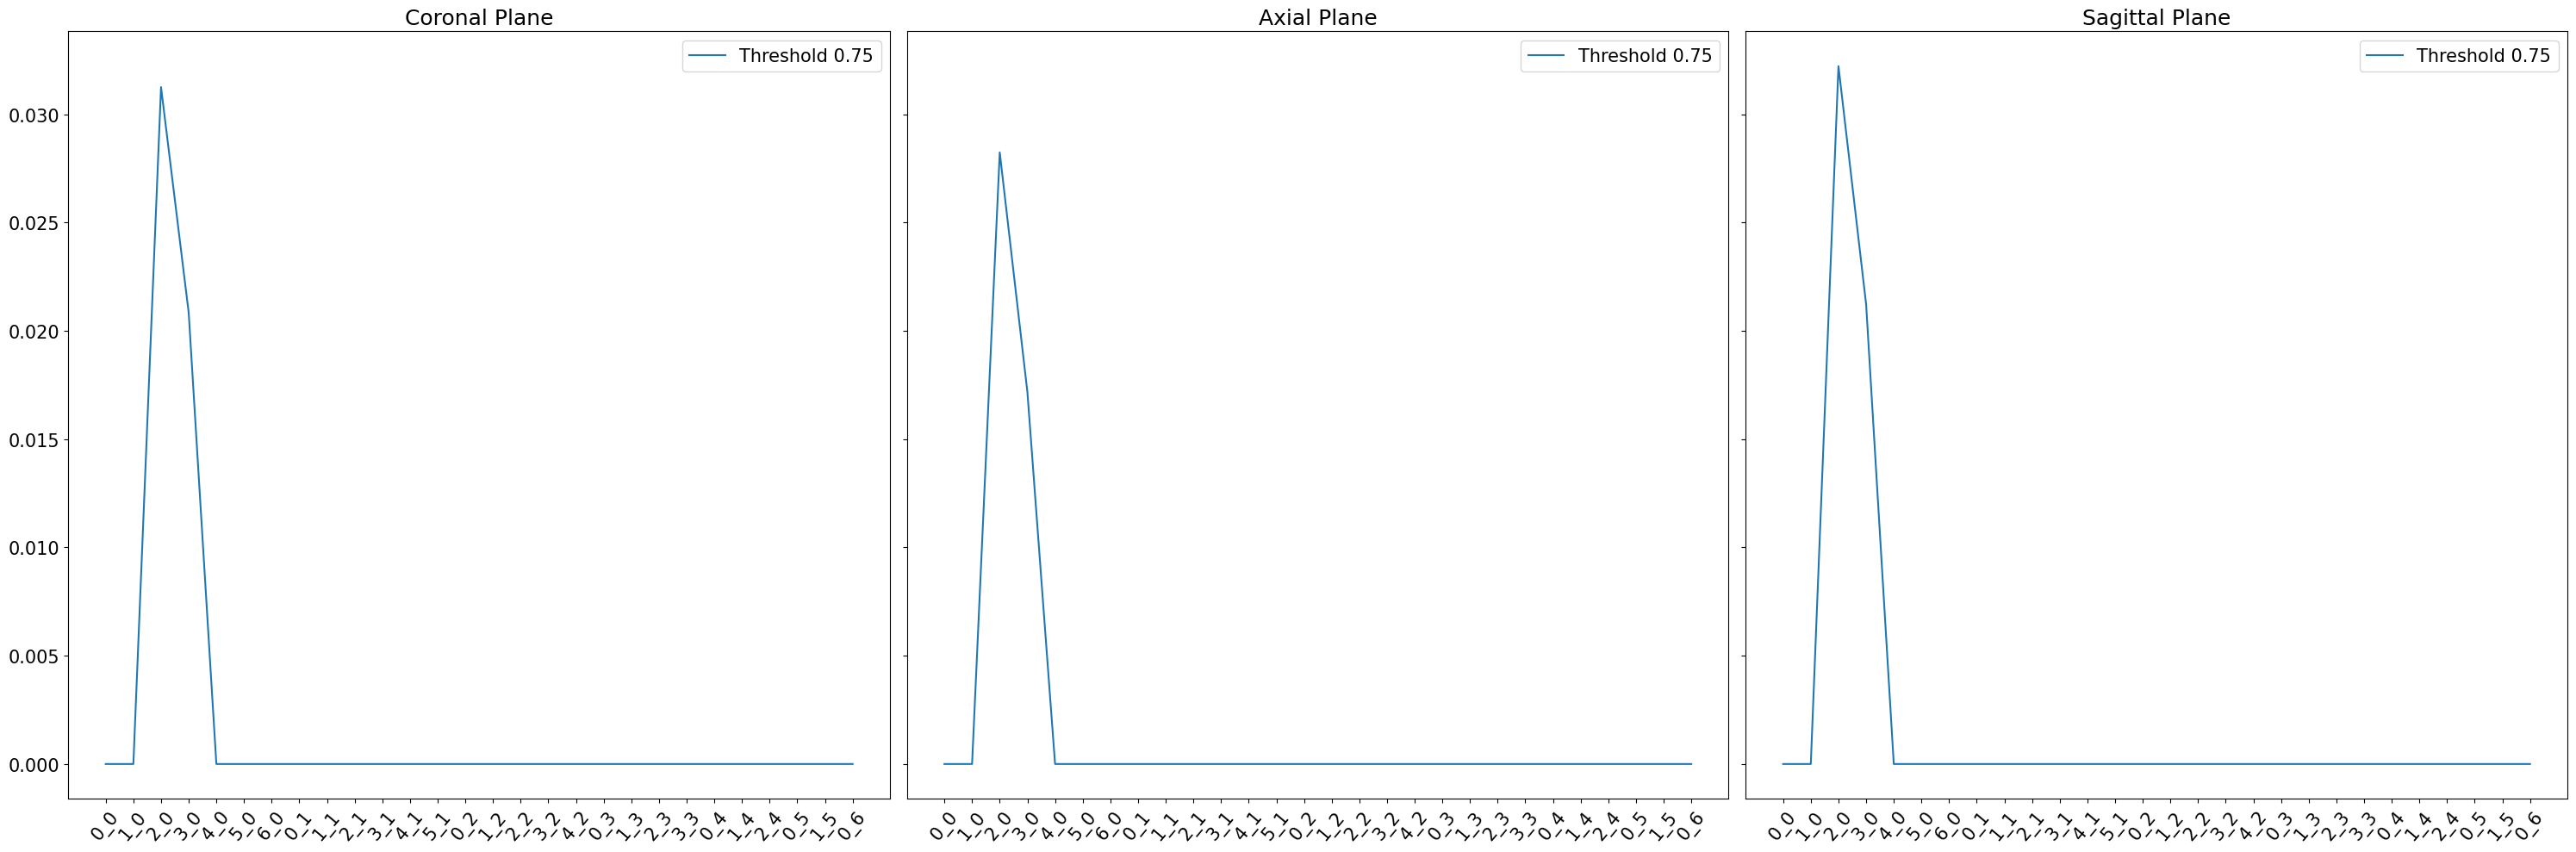

In [5]:
thresh075_sub = count_skipped_ops(f"/scratch/vinuyans/skips/slurm/t1.0_sub-0003002_60_ep1e-5.out")

sub_ratio={}


# sub_ratio.update(aggregate_per_threshold('1', thresh1_sub))
sub_ratio.update(aggregate_per_threshold('0.75', [thresh075_sub]))


fig, axes = plt.subplots(1, 3, figsize=(30,10), sharey=True)

for num, plane in enumerate(['coronal', 'axial', 'sagittal']):
# for num, plane in enumerate(['axial']):

    for thresh in ['0.75']:

        subs = np.array(list(sub_ratio[thresh][plane].values()))

        avg = np.mean( np.array(list(sub_ratio[thresh][plane].values())), axis=0)
        stdev = np.std( np.array(list(sub_ratio[thresh][plane].values())), axis=0)

        axes[num].plot(avg, label=f'Threshold {thresh}')
        axes[num].fill_between(range(len(avg)), avg - stdev, avg + stdev, alpha=0.3)
        # axes[num].set_ylim(-0.1,1)
        axes[num].set_title(f'{plane.title()} Plane', fontsize=18)
        axes[num].legend(fontsize=15)
        axes[num].set_xticks(np.arange(len(avg)), block_order, rotation=50, fontsize=13)
        axes[num].tick_params(axis='x', labelsize=15)  
        axes[num].tick_params(axis='y', labelsize=15)

plt.tight_layout()


**Threshold 0.5**

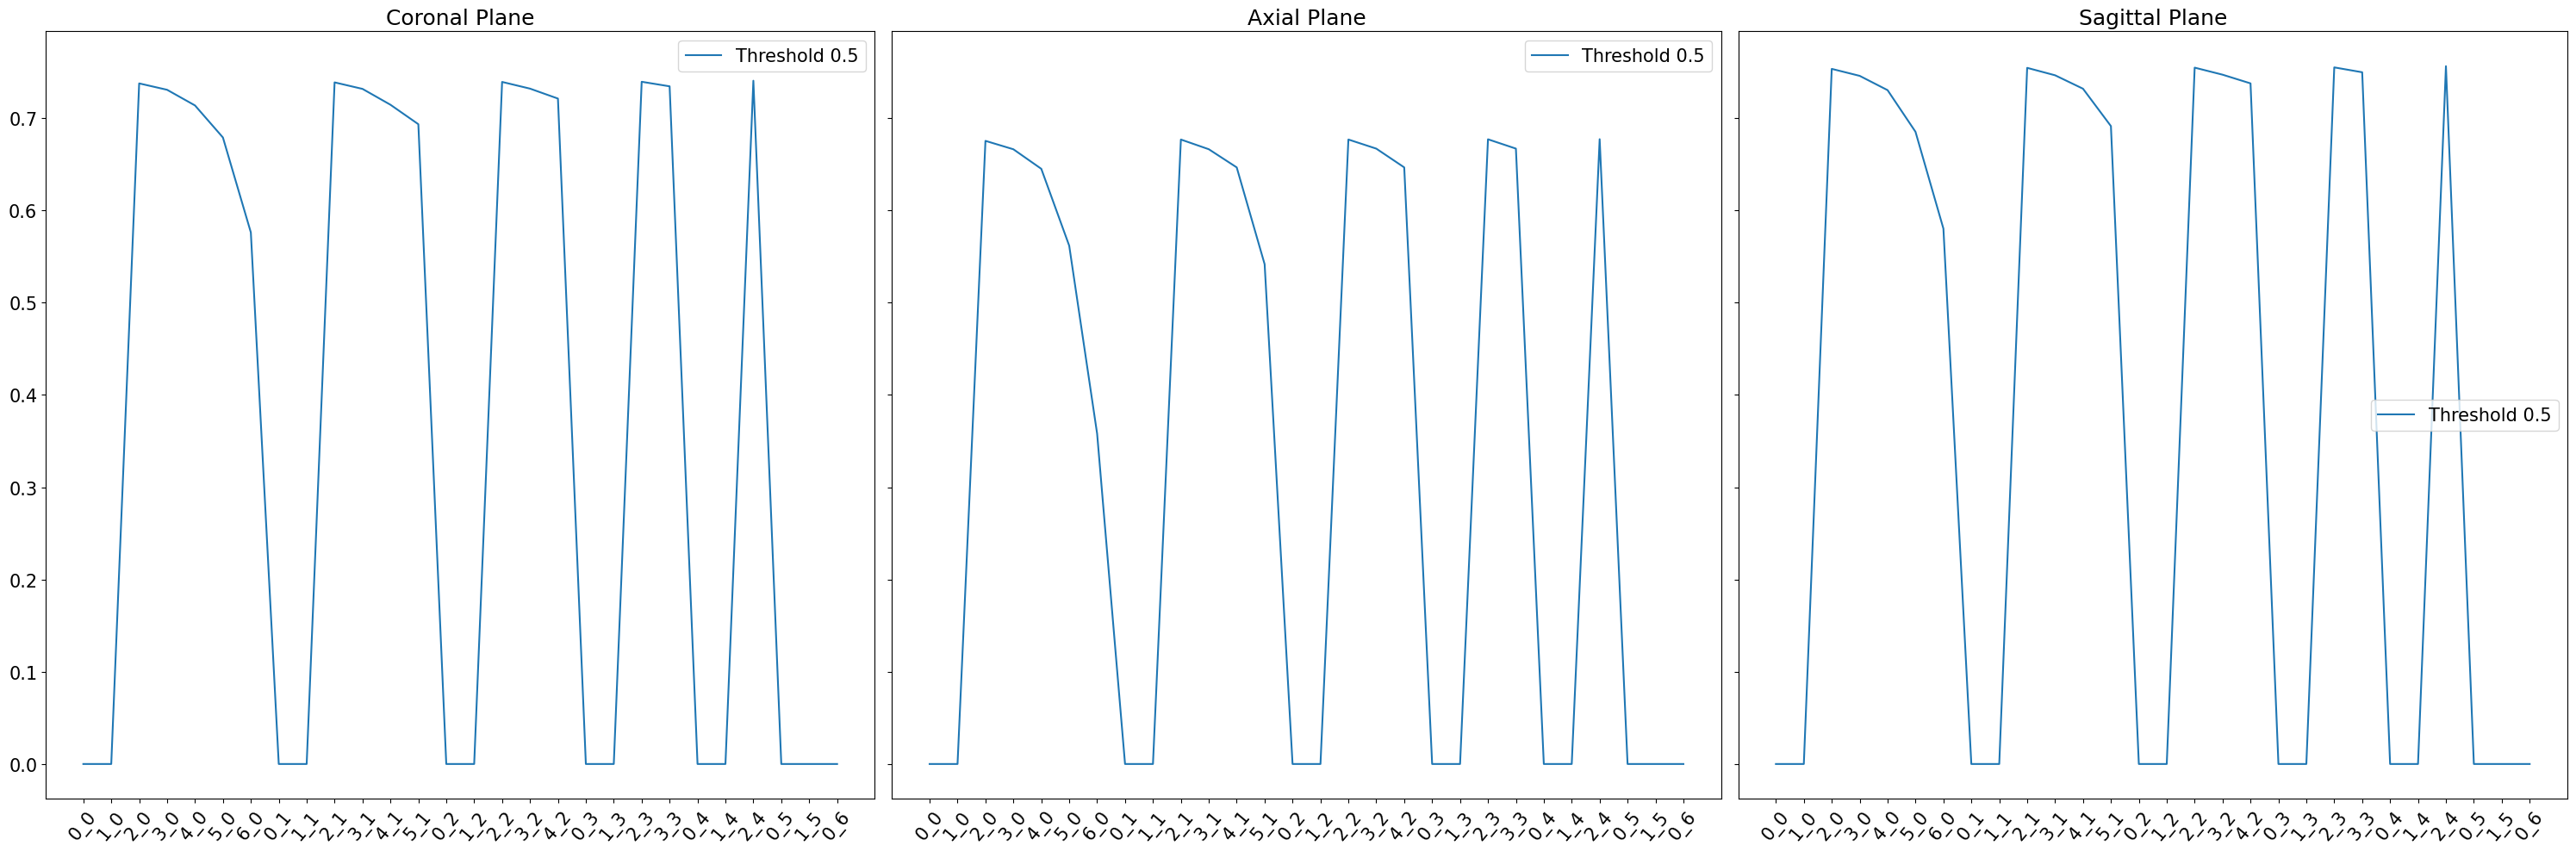

In [6]:
thresh075_sub = count_skipped_ops(f"/scratch/vinuyans/skips/slurm/t0.5_sub-0003002_60.out")

sub_ratio={}


# sub_ratio.update(aggregate_per_threshold('1', thresh1_sub))
sub_ratio.update(aggregate_per_threshold('0.5', [thresh075_sub]))


fig, axes = plt.subplots(1, 3, figsize=(30,10), sharey=True)

for num, plane in enumerate(['coronal', 'axial', 'sagittal']):
# for num, plane in enumerate(['axial']):

    for thresh in ['0.5']:

        subs = np.array(list(sub_ratio[thresh][plane].values()))

        avg = np.mean( np.array(list(sub_ratio[thresh][plane].values())), axis=0)
        stdev = np.std( np.array(list(sub_ratio[thresh][plane].values())), axis=0)

        axes[num].plot(avg, label=f'Threshold {thresh}')
        axes[num].fill_between(range(len(avg)), avg - stdev, avg + stdev, alpha=0.3)
        # axes[num].set_ylim(-0.1,1)
        axes[num].set_title(f'{plane.title()} Plane', fontsize=18)
        axes[num].legend(fontsize=15)
        axes[num].set_xticks(np.arange(len(avg)), block_order, rotation=50, fontsize=13)
        axes[num].tick_params(axis='x', labelsize=15)  
        axes[num].tick_params(axis='y', labelsize=15)

plt.tight_layout()


### Final Visualizations

In [ ]:
thresh1_sub = [count_skipped_ops(f"/scratch/vinuyans/skips/slurm/t1.0_sub-0003002_{i}.out") for i in range(128)]
thresh05_sub = [count_skipped_ops(f"/scratch/vinuyans/skips/slurm/t0.5_sub-0003002_{i}.out") for i in range(128)]

**Visualize Across Architectural Blocks**

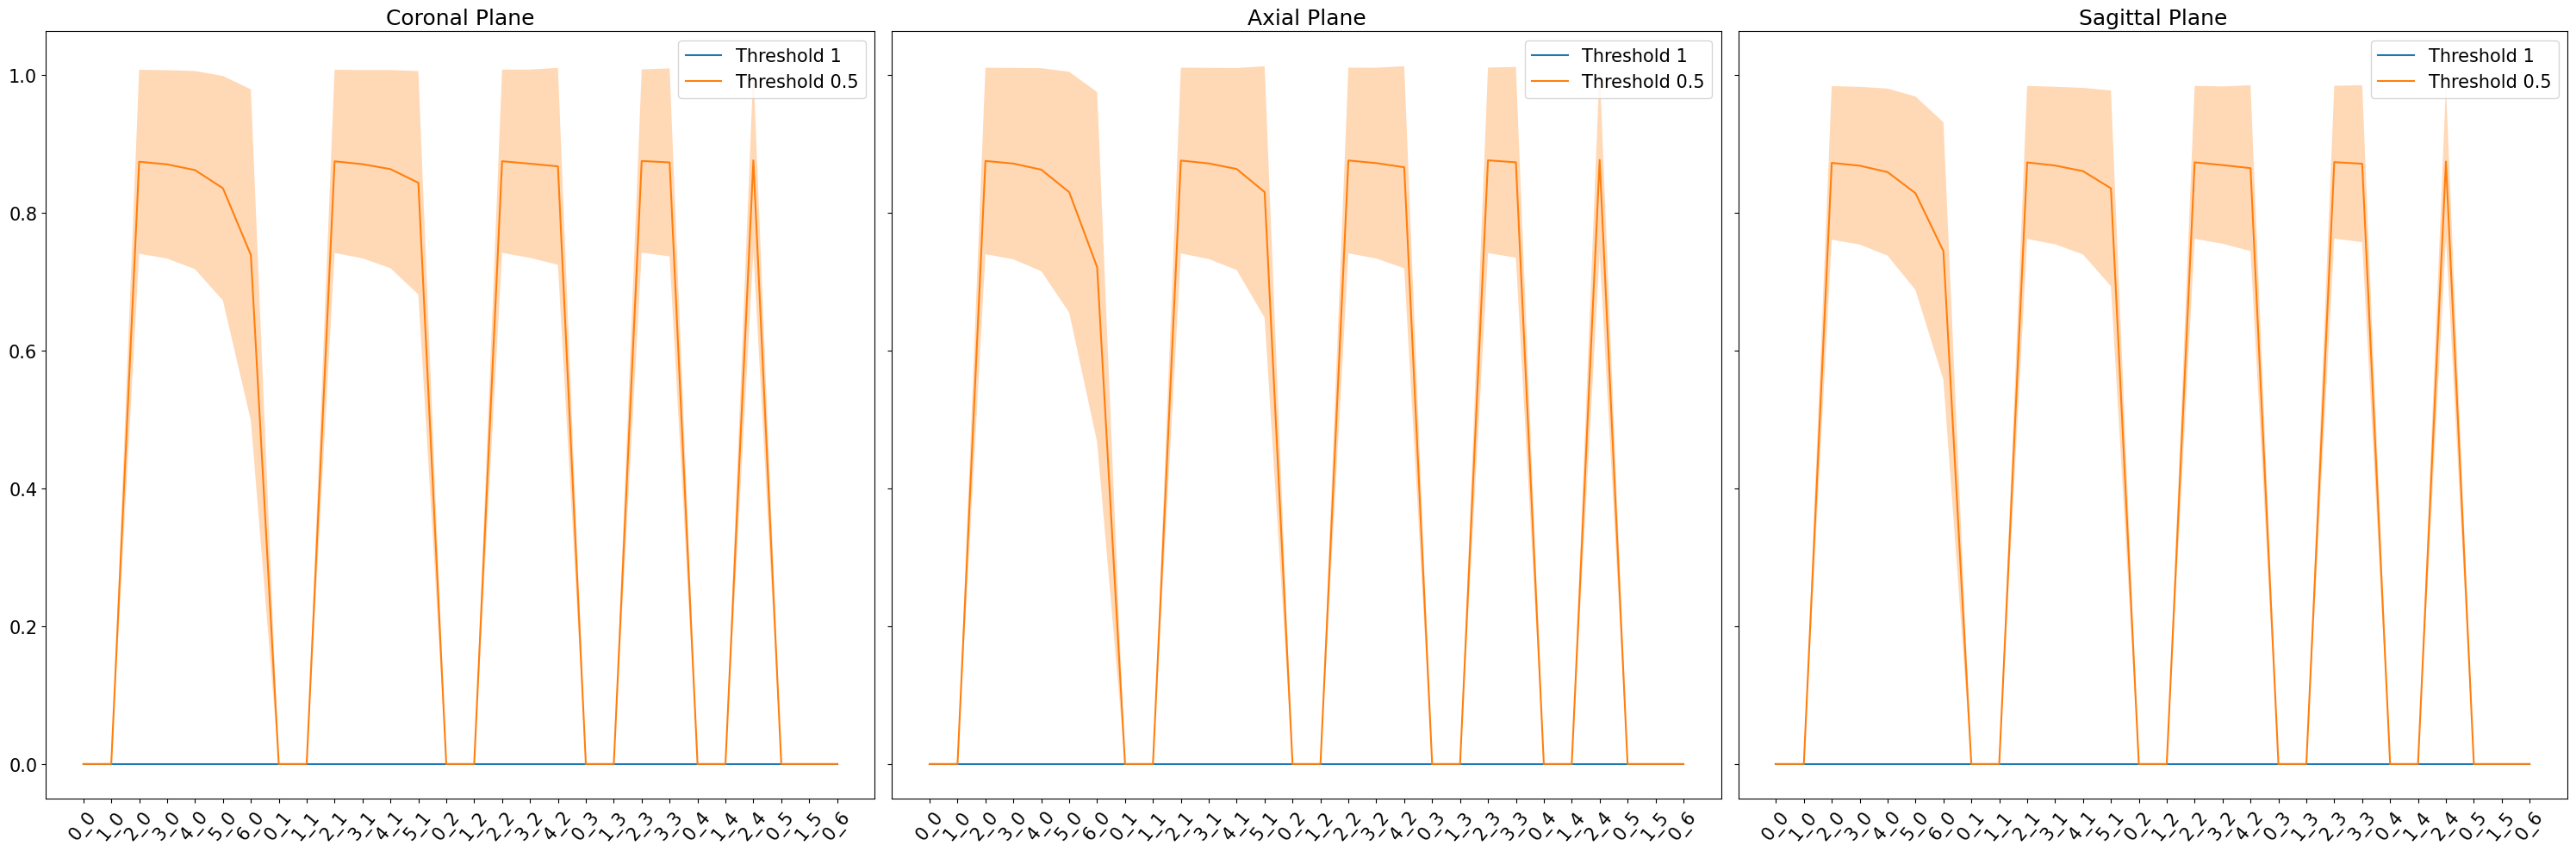

In [ ]:
block_order = ['0_0', '1_0', '2_0', '3_0', '4_0', '5_0', '6_0',
               '0_1', '1_1', '2_1', '3_1', '4_1', '5_1',
               '0_2', '1_2', '2_2', '3_2', '4_2',
               '0_3', '1_3', '2_3', '3_3',
               '0_4', '1_4', '2_4',
               '0_5', '1_5',
               '0_6']

# block_order = ['0_0',
#                '0_1', '1_0',
#                '0_2', '1_1', '2_0',
#                '0_3', '1_2', '2_1', '3_0',
#                '0_4', '1_3', '2_2', '3_1', '4_0',
#                '0_5', '1_4', '2_3', '3_2', '4_1', '5_0',
#                '0_6', '1_5', '2_4', '3_3', '4_2', '5_1', '6_0']

def aggregate_per_threshold(thresh, thresh_sub):

    sub_ratio = {thresh: {'coronal': {}, 'axial': {}, 'sagittal': {}} }


    for num, slice in enumerate(thresh_sub):
        # print(plane)
        # sub_ratio[:] = {}

        for plane in slice:

            sub_ratio[thresh][plane][num] = []

            # print(sub[plane])

            for block in block_order:
                sub_ratio[thresh][plane][num].append(np.mean(list(slice[plane][block].values())))
        
    return sub_ratio


# sub_ratio = {'1': {'coronal': {}, 'axial': {}, 'sagittal': {}}, '0.5': {'coronal': {}, 'axial': {}, 'sagittal': {}} }
sub_ratio = {}

sub_ratio.update(aggregate_per_threshold('1', thresh1_sub))
sub_ratio.update(aggregate_per_threshold('0.5', thresh05_sub))


fig, axes = plt.subplots(1, 3, figsize=(30,10), sharey=True)

for num, plane in enumerate(['coronal', 'axial', 'sagittal']):
# for num, plane in enumerate(['axial']):

    for thresh in ['1', '0.5']:

        subs = np.array(list(sub_ratio[thresh][plane].values()))

        avg = np.mean( np.array(list(sub_ratio[thresh][plane].values())), axis=0)
        stdev = np.std( np.array(list(sub_ratio[thresh][plane].values())), axis=0)

        axes[num].plot(avg, label=f'Threshold {thresh}')
        axes[num].fill_between(range(len(avg)), avg - stdev, avg + stdev, alpha=0.3)
        # axes[num].set_ylim(-0.1,1)
        axes[num].set_title(f'{plane.title()} Plane', fontsize=18)
        axes[num].legend(fontsize=15)
        axes[num].set_xticks(np.arange(len(avg)), block_order, rotation=50, fontsize=13)
        axes[num].tick_params(axis='x', labelsize=15)  
        axes[num].tick_params(axis='y', labelsize=15)

plt.tight_layout()


**Visualize Across Brain Slices**

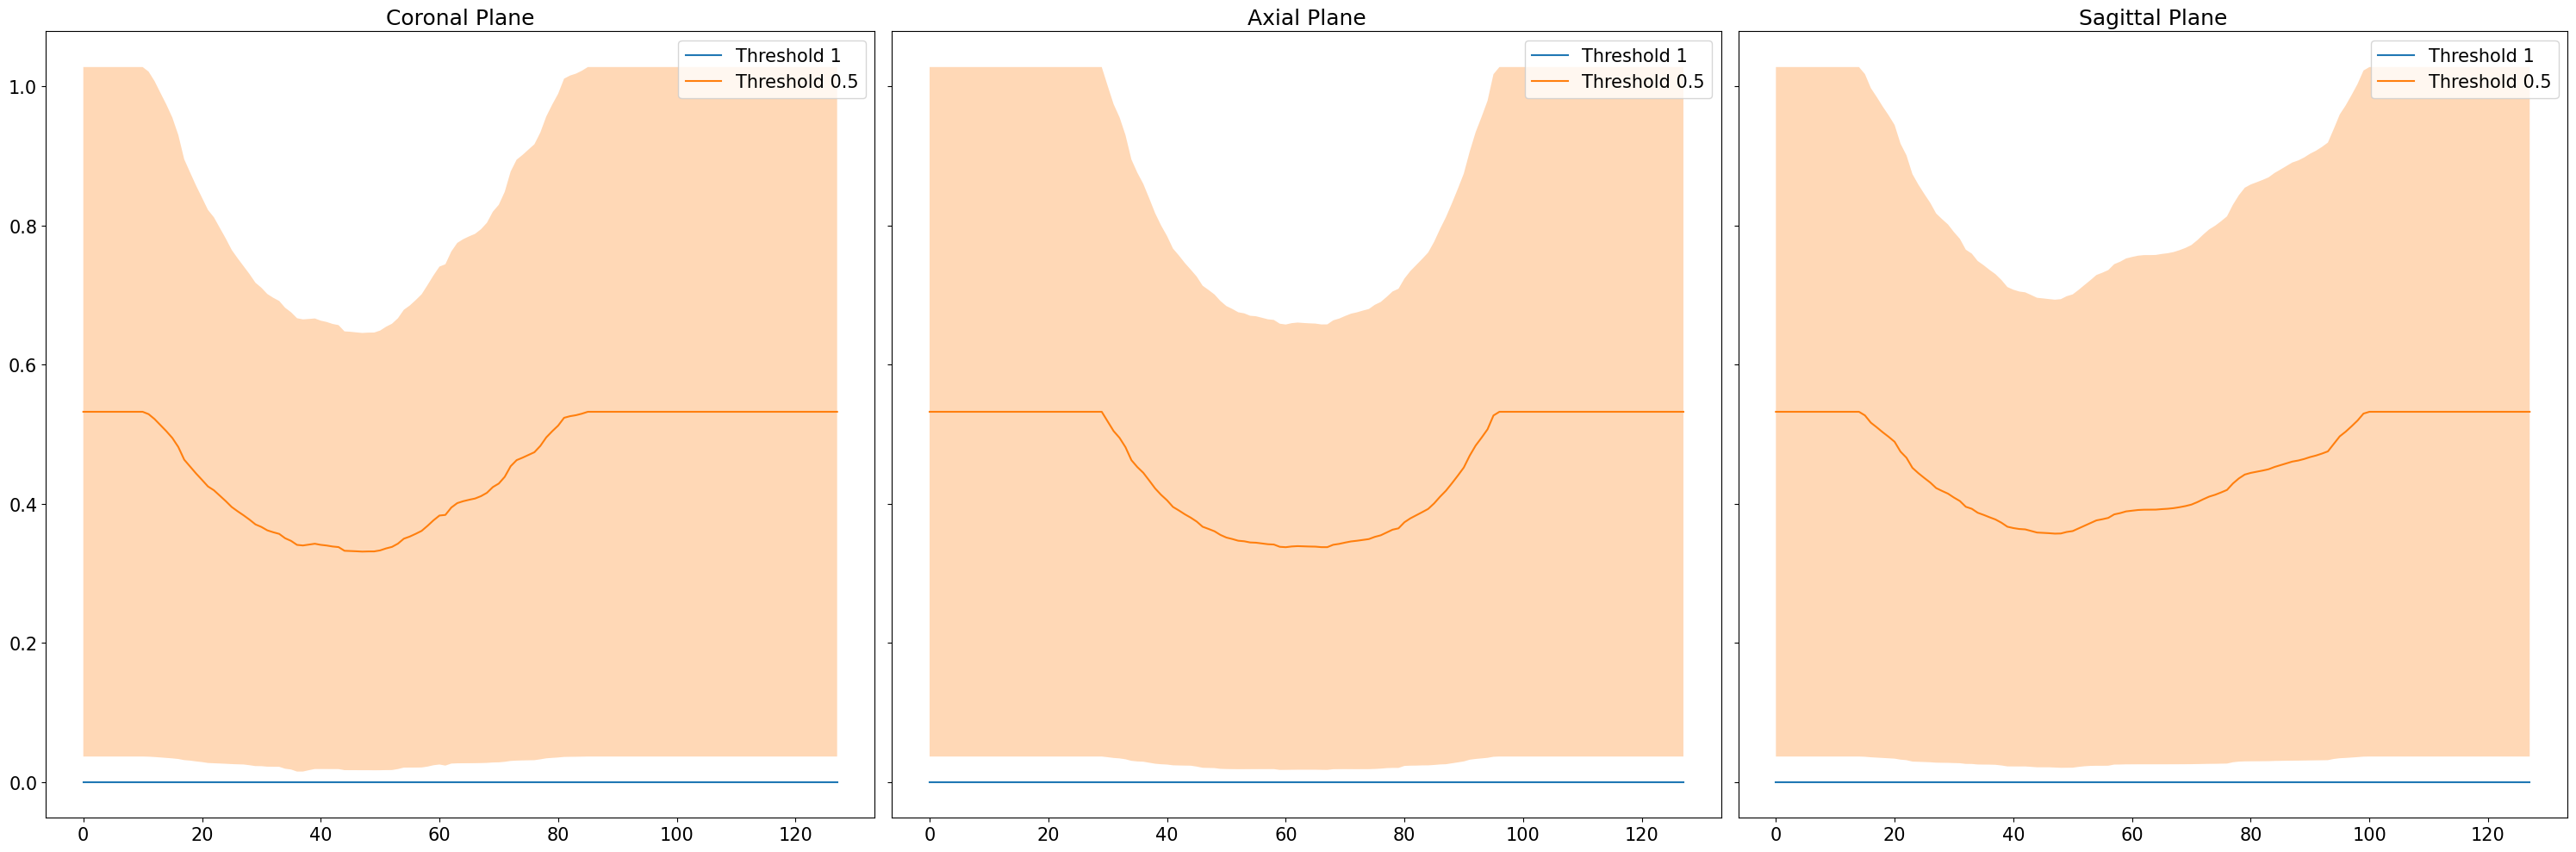

In [ ]:
sub_ratio = {}

sub_ratio.update(aggregate_per_threshold('1', thresh1_sub))
sub_ratio.update(aggregate_per_threshold('0.5', thresh05_sub))


fig, axes = plt.subplots(1, 3, figsize=(30,10), sharey=True)

for num, plane in enumerate(['coronal', 'axial', 'sagittal']):

    for thresh in ['1', '0.5']:

        subs = np.array(list(sub_ratio[thresh][plane].values()))

        avg = np.mean( np.array(list(sub_ratio[thresh][plane].values())), axis=1)
        stdev = np.std( np.array(list(sub_ratio[thresh][plane].values())), axis=1)

        axes[num].plot(avg, label=f'Threshold {thresh}')
        axes[num].fill_between(range(len(avg)), avg - stdev, avg + stdev, alpha=0.3)
        # axes[num].set_ylim(-0.1,1)
        axes[num].set_title(f'{plane.title()} Plane', fontsize=18)
        axes[num].legend(fontsize=15)
        axes[num].tick_params(axis='x', labelsize=15)  
        axes[num].tick_params(axis='y', labelsize=15)  

plt.tight_layout()


## SNR

In [ ]:
#GLOBAL SNR
snr = lambda  x : x.mean()/x.std()

views = {
    'Axial': (127, slice(None), slice(None)),
    'Coronal': (slice(None), 127, slice(None)),
    'Sagittal': (slice(None), slice(None), 127)
}

def calculate_local_snr(image, patch_size=3):
    """
    Calculate the local SNR of a 2D brain slice image using scipy.ndimage.
    
    Parameters:
    - image: 2D NumPy array, the brain slice image
    - patch_size: int, the size of the patches to divide the image into
    
    Returns:
    - snr_map: 2D NumPy array, the local SNR values
    """
    # Ensure the image is a 2D array
    if len(image.shape) != 2:
        raise ValueError("Input image must be a 2D array.")
    # Calculate local mean
    local_mean = ndimage.uniform_filter(image, size=patch_size)
    
    # Calculate local squared mean
    local_sq_mean = ndimage.uniform_filter(image**2, size=patch_size)
    
    # Calculate local variance (E[X^2] - (E[X])^2)
    local_variance = local_sq_mean - local_mean**2
    
    # Calculate local standard deviation
    local_std = np.sqrt(local_variance)
    
    # Avoid division by zero
    local_std[local_std == 0] = np.finfo(float).eps
    
    # Calculate local SNR (mean / std)
    snr_map = local_mean / local_std
    
    return np.abs(snr_map)


def plot_single_compare(nan_out, ieee, base, nan_thresh, view):
    fig, axes = plt.subplots(2, 3, figsize=(25,10))
    view_index = views[view]
    out = nib.load(os.path.join(nan_out)).get_fdata()
    gc = sns.heatmap(out[view_index].squeeze(), ax=axes[0][0])
    gc.set_title(f'NaN {nan_thresh} Output')
    gc.set_ylabel(f"{view} View")

    out = nib.load(os.path.join(ieee)).get_fdata()
    gc = sns.heatmap(out[view_index].squeeze(), ax=axes[0][1])
    gc.set_title(f'IEEE Single Segment Output')

    out = nib.load(os.path.join(base)).get_fdata()
    gc = sns.heatmap(out[view_index].squeeze(), ax=axes[0][2])
    gc.set_title(f'Original MRI')

    snr = lambda  x : x.mean()/x.std()

    out = nib.load(os.path.join(nan_out)).get_fdata()
    nan = calculate_local_snr(out[view_index])
    gc = sns.heatmap(nan, ax=axes[1][0], vmin=0, vmax=200)
    gc.set_title(f'NaN {nan_thresh} Output - Global SNR: {snr(out[view_index])}')
    gc.set_ylabel("Local SNR")

    out = nib.load(os.path.join(ieee)).get_fdata()
    ieee = calculate_local_snr(out[view_index])
    gc = sns.heatmap(ieee, ax=axes[1][1], vmin=0, vmax=200)
    gc.set_title(f'IEEE Single Segment Output - Global SNR: {snr(out[view_index])}')
    
    out = nib.load(os.path.join(base)).get_fdata()
    gc = sns.heatmap(calculate_local_snr(out[view_index]), ax=axes[1][2], vmin=0, vmax=200)
    gc.set_title(f'Original MRI - Global SNR: {snr(out[view_index])}')

    plt.suptitle(f"Absolute Error - Nan SNR vs IEEE SNR", y=1.02, fontsize=15)
    
    fig, axes = plt.subplots(1, 1, figsize=(15,10))
    gc = sns.heatmap(nan - ieee, ax=axes, vmin=-100, vmax=100, cmap='RdYlGn')
    gc.set_title(f'IEEE Single Segment Output - Global SNR: {snr(out[view_index])}')

def get_slices(mri, view):
    if view == 'Sagittal':
        return [mri[i, :, :] for i in range(mri.shape[0])]
    elif view == 'Axial':
        return [mri[:, i, :] for i in range(mri.shape[1])]
    else:
        return [mri[:, :, i] for i in range(mri.shape[2])]

def plot_final_compare(nan_out, ieee_whole, view, nan_thresh=1.0):
    # snr = lambda  x : x.mean()/x.std()
    snr = lambda x: np.nanmean(x) / np.nanstd(x)
    nan_result = nib.load(os.path.join(nan_out))
    ieee_results = nib.load(os.path.join(ieee_whole))
    
    # Compute the brain mask from the entire nan_result image
    mask_nan = masking.compute_brain_mask(nan_result)
    mask_ieee = masking.compute_brain_mask(nan_result)
    
    nan_result = nan_result.get_fdata()
    ieee_results = ieee_results.get_fdata()
    
    nan_slices = get_slices(nan_result, view)
    ieee_slices = get_slices(ieee_results, view)
    
    for i in range(0, len(nan_slices), 5):    
        fig, axes = plt.subplots(1, 4, figsize=(18,5))
        nan = calculate_local_snr(nan_slices[i])
        gc = sns.heatmap(nan, ax=axes[0], vmin=0, vmax=200)
        gc.set_title(f'NaN - Global SNR: {round(snr(nan_slices[i] * np.where(nan_slices[i] > 5.0, nan_slices[i], np.nan)), 4)}')
        gc.set_ylabel(view)

        
        ieee = calculate_local_snr(ieee_slices[i])
        gc = sns.heatmap(ieee, ax=axes[1], vmin=0, vmax=200)
        gc.set_title(f'IEEE - Global SNR: {round(snr(ieee_slices[i]* np.where(ieee_slices[i] > 5.0, ieee_slices[i], np.nan)), 4)}')        
        
        gc = sns.heatmap(nan - ieee, ax=axes[2], vmin=-50, vmax=50, cmap='RdYlGn')
        gc.set_title(f'Difference between Nan and IEEE SNR')
        
        
        gc = sns.heatmap(ieee_slices[i], ax=axes[3])
        gc.set_title(f'IEEE Output')  
    
        plt.suptitle(f"Nan {nan_thresh}  SNR vs IEEE SNR - Slice {i}", y=1.02, fontsize=15)
        
        plt.show()

tensor(0.7356)


/home/ine5/dynamo_env/lib/python3.10/site-packages/nilearn/masking.py:665: _MaskWarning: Computed an empty mask. whole-brain mask is empty, lower the threshold or check your input FOV
  mask, affine = _post_process_mask(


torch.Size([2, 1, 256, 256]) (2, 1, 256) (2, 2, 256, 256)


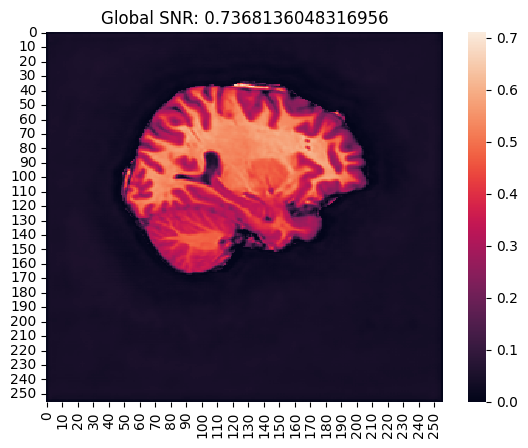

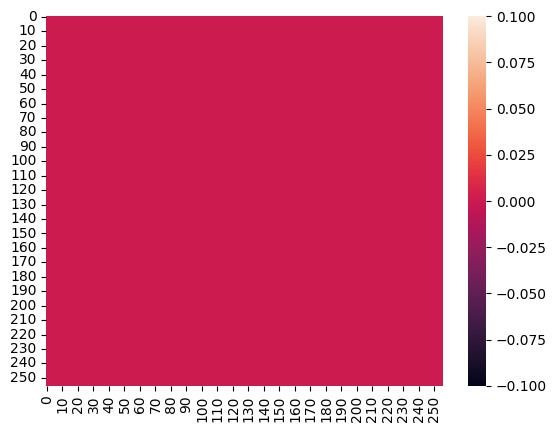

In [ ]:
from nilearn.image import new_img_like

a = pickle.load(open(f"/scratch/vinuyans/skips/thresh1/axial/50_slice.pkl", "rb"))
a.shape

#Create 

snr = lambda  x : x.mean()/x.std()
print(snr(a[0]))

# out = nib.load(os.path.join(nan_out)).get_fdata()
# nan = calculate_local_snr(out[view_index])
gc = sns.heatmap(a.squeeze()[0])
gc.set_title(f'Global SNR: {snr(a)}')
# gc.set_ylabel("Local SNR")

# Compute the brain mask from the entire nan_result image
# mask_nan = masking.compute_brain_mask(nan_result)
affine = np.diag([1, 2, 3, 1])
array_img = nib.Nifti1Image(a.numpy(), affine) #replace with IEEE affine

mask_ieee = masking.compute_brain_mask(array_img )


masked_img = new_img_like(array_img, a.numpy() * mask_ieee.get_fdata() )

print(a.shape, mask_ieee.get_fdata().shape, masked_img.shape)

plt.show()
gc = sns.heatmap(masked_img.get_fdata()[0,0])



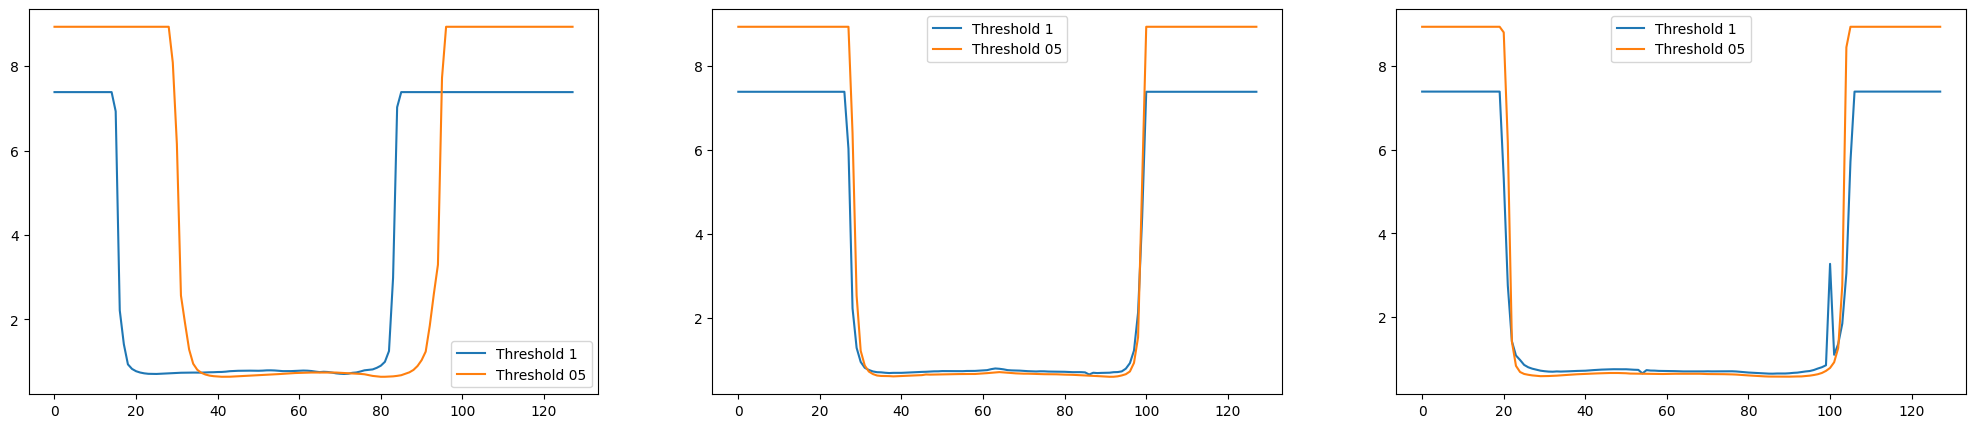

In [ ]:
def global_snr_across_slices(filedir):

    fig, axes = plt.subplots(1, 3, figsize=(25,5))
    snr = lambda  x : x.mean()/x.std()


    for num, plane in enumerate(['coronal', 'axial', 'sagittal']):
        
        for thresh in ['1', '05']:
            snr_slices = []

            for i in range(128):

                a = pickle.load(open(f"{filedir}/thresh{thresh}/{plane}/{i}_slice.pkl", "rb"))
    
                #Create MASK FROM IEEE

                snr_slices.append(snr(a).item())

            axes[num].plot(snr_slices, label=f'Threshold {thresh}')
        axes[num].legend()
        # break


global_snr_across_slices('/scratch/vinuyans/skips')